# Intelligent Systems for Bioinformatics Curricular Unit
## Group 3:
- Christian Neitzel
- Diana Silva
- Ian Alves
- Samuel Baptista

# **Section 1:** Initial data exploration and preprocessing

## Drug Synergy Prediction Task Overview:
**Definition:** Synergy is a dimensionless measure of deviation of an observed drug combination response from the expected effect of non-interaction. Synergy can be calculated using different models such as the Bliss model, Highest Single Agent (HSA), Loewe additivity model and Zero Interaction Potency (ZIP). Another relevant metric is CSS which measures the drug combination sensitivity and is derived using relative IC50 values of compounds and the area under their dose- response curves.

**Impact:** Drug combination therapy offers enormous potential for expanding the use of existing drugs and in improving their efficacy. For instance, the simultaneous modulation of multiple targets can address the common mechanisms of drug resistance in the treatment of cancers. However, experimentally exploring the entire space of possible drug combinations is not a feasible task. Computational models that can predict the therapeutic potential of drug combinations can thus be immensely valuable in guiding this exploration.

**Generalization:** It is important for model predictions to be able to adapt to varying underlying biology as captured through different cell lines drawn from multiple tissues of origin. Dosage is also an important factor that can impact model generalizability.

**Product:** Small-molecule.

**Pipeline:** Activity.

## Dataset: **OncoPolyPharmacology**

**Dataset Description:** A large-scale oncology screen produced by Merck & Co., where each sample consists of two compounds and a cell line. The dataset covers 583 distinct combinations, each tested against 39 human cancer cell lines derived from 7 different tissue types (lung, breast, ovarian, colon, melanoma, prostate, and other/unspecified types), ensuring a wide representation of cancer biology and enabling generalization of drug synergy predictions across multiple cancer types.

**Drug Pairs and Targets:** Pairwise combinations were constructed from 38 diverse anticancer drugs (14 experimental and 24 approved), targeting pathways such as DNA damage repair, cell cycle regulation, and kinase signaling. Examples of novel synergistic combinations include the Wee1 inhibitor (AZD1775) and the mTOR inhibitor (ridaforolimus), which showed potent activity in ovarian cancer models.

**Synergy Scoring:** Synergy quantifies the deviation from non-interaction, with positive scores indicating synergistic effects and negative scores indicating antagonistic interactions. Most combinations exhibit additive or no effects, with true synergy being rare. The synergy score is calculated by Loewe Additivity values using the batch processing mode of Combenefit.

**Experimental Design:** Drug combinations were tested using a 4x4 dose-response matrix, capturing the interactions between drugs at varying concentrations. Cell viability was measured relative to untreated controls, and synergy scores were calculated using the Loewe Additivity Model, which assumes that if two drugs act without interaction, their combined effect should match the sum of their individual effects. Deviations from this additive effect indicate synergy (positive scores) or antagonism (negative scores). Some combinations were tested exhaustively in pairwise fashion, while others followed a supplemental strategy where specific drugs were tested selectively. Synergy and antagonism were found to be relatively rare phenomena. Known synergistic pairs, like the PARP inhibitor and temozolomide, were validated, and promising combinations, like Wee1 and mTOR inhibitors, were tested in xenograft models, demonstrating significant tumor growth inhibition and prolonged survival compared to monotherapy.

**Gene Expression Features:** Genomic data for cell lines was derived from untreated cell lines. The genomic features are from ArrayExpress database (accession number: E-MTAB-3610). Features were quantile normalized and summarized with Factor Analysis for Robust Microarray Summarization (FARMS) algorithm, resulting in 3,984 robust genomic descriptors.

**Dataset Utility:**
This dataset is a multimodal resource, integrating chemical descriptors (SMILES strings) and genomic data for cell lines to predict drug synergy. It addresses the experimental infeasibility of testing all potential drug combinations and offers computational researchers a valuable tool to guide drug discovery. By providing insights into context-specific drug interactions, it has the potential to improve precision medicine approaches in oncology.

**Task Description:** Regression. Given the gene expression of cell lines and two SMILES strings of the drug combos, predict the drug synergy level.

**Dataset Statistics:** **23,052 drug combo-cell line points**, among **39 cancer cell lines** and **37 drugs**

**Note:** The processed data is provided by DeepSynergy.

## References and links:

[https://tdcommons.ai/multi_pred_tasks/drugsyn](https://tdcommons.ai/multi_pred_tasks/drugsyn)

[https://aacrjournals.org/mct/article/15/6/1155/92159/An-Unbiased-Oncology-Compound-Screen-to-Identify](https://aacrjournals.org/mct/article/15/6/1155/92159/An-Unbiased-Oncology-Compound-Screen-to-Identify)

[1]	J. O’Neil et al., “An Unbiased Oncology Compound Screen to Identify Novel Combination Strategies,” Molecular Cancer Therapeutics, vol. 15, no. 6, pp. 1155–1162, Jun. 2016, doi: 10.1158/1535-7163.MCT-15-0843

[https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false](https://academic.oup.com/bioinformatics/article/34/9/1538/4747884?login=false)

[2]	K. Preuer, R. P. I. Lewis, S. Hochreiter, A. Bender, K. C. Bulusu, and G. Klambauer, “DeepSynergy: predicting anti-cancer drug synergy with Deep Learning,” Bioinformatics, vol. 34, no. 9, pp. 1538–1546, May 2018, doi: 10.1093/bioinformatics/btx806



## Imports

In [2]:
from tdc.multi_pred import DrugSyn

import pandas as pd
import numpy as np

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


## Data load and exploration

The OncoPolyPharmacology dataset contains 7 columns:

- **Drug_1_ID**: Contains the drug 1 ids
- **Drug_2_ID**: Contains the drug 2 ids
- **Cell_Line_ID**: Contains the cell line ids
- **Y**: Contains the synergy score (label)
- **Cell_Line**: Contains the genomic features for cell lines (inside a list)
- **Drug1**: Contains the drug 1 smiles representations
- **Drug2**: Contains the drug 2 smiles representations

In [3]:
data = DrugSyn(name = 'OncoPolyPharmacology')
dataset = data.get_data()
print(dataset.shape)
dataset.head()

Found local copy...
Loading...
Done!


(23052, 7)


Drug1_ID Drug2_ID Cell_Line_ID         Y  \
0     5-FU  ABT-888        A2058  7.693530   
1     5-FU  ABT-888        A2780  7.778053   
2     5-FU  ABT-888         A375 -1.198505   
3     5-FU  ABT-888         A427  2.595684   
4     5-FU  ABT-888        CAOV3 -5.139971   

                                           Cell_Line                    Drug1  \
0  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
1  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
2  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
3  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
4  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   

                                Drug2  
0  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
1  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
2  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
3  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
4  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1

In [4]:
# general information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23052 entries, 0 to 23051
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Drug1_ID      23052 non-null  object 
 1   Drug2_ID      23052 non-null  object 
 2   Cell_Line_ID  23052 non-null  object 
 3   Y             23052 non-null  float64
 4   Cell_Line     23052 non-null  object 
 5   Drug1         23052 non-null  object 
 6   Drug2         23052 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB


Before advancing, we confirmed that the dataset has no missing values in any column.

In [5]:
# check missing values
dataset.isnull().sum()

Drug1_ID        0
Drug2_ID        0
Cell_Line_ID    0
Y               0
Cell_Line       0
Drug1           0
Drug2           0
dtype: int64

In [6]:
unique_drug1_id = dataset['Drug1_ID'].value_counts()
print(unique_drug1_id)

Drug1_ID
MRK-003             1449
MK-4541             1443
L778123             1005
ZOLINZA              858
5-FU                 795
SUNITINIB            795
MITOMYCINE           795
VINBLASTINE          780
PACLITAXEL           780
METHOTREXATE         780
METFORMIN            780
CARBOPLATIN          780
CYCLOPHOSPHAMIDE     780
DEXAMETHASONE        780
DOXORUBICIN          780
TEMOZOLOMIDE         771
AZD1775              747
VINORELBINE          741
ETOPOSIDE            741
GEMCITABINE          732
LAPATINIB            678
MK-5108              624
MK-4827              615
MK-2206              576
ERLOTINIB            507
PD325901             468
BORTEZOMIB           429
DASATINIB            405
ABT-888              351
MK-8669              312
GELDANAMYCIN         273
BEZ-235              195
TOPOTECAN            156
SN-38                117
OXALIPLATIN          117
SORAFENIB             78
DINACICLIB            39
Name: count, dtype: int64


In [7]:
unique_drug2_id = dataset['Drug2_ID'].value_counts()
print(unique_drug2_id)

Drug2_ID
MK-8776             1548
DINACICLIB          1404
SORAFENIB           1365
BEZ-235             1263
GELDANAMYCIN        1170
MK-8669             1161
ABT-888             1092
DASATINIB           1068
BORTEZOMIB          1014
PD325901             975
ERLOTINIB            951
MK-2206              927
MK-4827              873
MK-5108              819
LAPATINIB            795
AZD1775              771
SN-38                756
OXALIPLATIN          741
TEMOZOLOMIDE         702
TOPOTECAN            702
SUNITINIB            678
ZOLINZA              585
L778123              468
GEMCITABINE          156
ETOPOSIDE            117
VINORELBINE          117
VINBLASTINE           93
CARBOPLATIN           78
5-FU                  78
CYCLOPHOSPHAMIDE      78
DEXAMETHASONE         78
METFORMIN             78
DOXORUBICIN           78
METHOTREXATE          78
MITOMYCINE            78
PACLITAXEL            78
MRK-003               39
Name: count, dtype: int64


In [8]:
unique_drug1_id = set(dataset['Drug1_ID'].unique())
print(unique_drug1_id)
unique_drug2_id = set(dataset['Drug2_ID'].unique())
print(unique_drug2_id)

# check if unique drug1 are the same as unique drug2
if unique_drug1_id == unique_drug2_id:
    print("Unique drug1 match unique drug2")
else:
    print("Unique drug1 don't match unique drug2")

{'AZD1775', 'ABT-888', 'DEXAMETHASONE', 'SUNITINIB', 'MK-8669', 'TOPOTECAN', 'DINACICLIB', 'MK-2206', 'CYCLOPHOSPHAMIDE', 'MK-4541', 'VINBLASTINE', 'GEMCITABINE', 'ETOPOSIDE', 'SN-38', 'DASATINIB', 'VINORELBINE', 'MK-5108', '5-FU', 'SORAFENIB', 'BEZ-235', 'OXALIPLATIN', 'PACLITAXEL', 'ERLOTINIB', 'TEMOZOLOMIDE', 'METHOTREXATE', 'MRK-003', 'GELDANAMYCIN', 'METFORMIN', 'ZOLINZA', 'LAPATINIB', 'BORTEZOMIB', 'L778123', 'MK-4827', 'CARBOPLATIN', 'DOXORUBICIN', 'MITOMYCINE', 'PD325901'}
{'AZD1775', 'ABT-888', 'SUNITINIB', 'DEXAMETHASONE', 'MK-8669', 'TOPOTECAN', 'DINACICLIB', 'MK-2206', 'CYCLOPHOSPHAMIDE', 'VINBLASTINE', 'GEMCITABINE', 'ETOPOSIDE', 'SN-38', 'DASATINIB', 'MK-8776', 'VINORELBINE', 'MK-5108', '5-FU', 'SORAFENIB', 'BEZ-235', 'OXALIPLATIN', 'PACLITAXEL', 'ERLOTINIB', 'TEMOZOLOMIDE', 'METHOTREXATE', 'MRK-003', 'GELDANAMYCIN', 'ZOLINZA', 'METFORMIN', 'LAPATINIB', 'BORTEZOMIB', 'L778123', 'MK-4827', 'CARBOPLATIN', 'DOXORUBICIN', 'MITOMYCINE', 'PD325901'}
Unique drug1 don't match uni

In order to perform the machine learning pipeline *aposteriori*, we splited the dataset in train, validation and test sets with a proportion of 0.7, 0.1 and 0.2, respectively.

In [9]:
split = data.get_split(frac=[0.8, 0, 0.2])
split

{'train':       Drug1_ID   Drug2_ID  Cell_Line_ID          Y  \
 0         5-FU    ABT-888         A2058   7.693530   
 1         5-FU    ABT-888         A2780   7.778053   
 2         5-FU    ABT-888          A375  -1.198505   
 3         5-FU    ABT-888         CAOV3  -5.139971   
 4         5-FU    ABT-888     COLO320DM   4.175936   
 ...        ...        ...           ...        ...   
 18437  ZOLINZA  TOPOTECAN          T47D  18.985100   
 18438  ZOLINZA  TOPOTECAN        UACC62  10.223066   
 18439  ZOLINZA  TOPOTECAN  UWB1289BRCA1  20.551627   
 18440  ZOLINZA  TOPOTECAN       UWB1289  12.190316   
 18441  ZOLINZA  TOPOTECAN         ZR751  12.223791   
 
                                                Cell_Line  \
 0      [5.291146039856301, 5.040386719464342, 5.29114...   
 1      [5.291146039856301, 5.040386719464342, 5.29114...   
 2      [5.291146039856301, 5.040386719464342, 5.29114...   
 3      [5.291146039856301, 5.040386719464342, 5.29114...   
 4      [5.2911460398563

In [10]:
train_data = split['train']
print(train_data.shape)
train_data.head()

(18442, 7)


Drug1_ID Drug2_ID Cell_Line_ID         Y  \
0     5-FU  ABT-888        A2058  7.693530   
1     5-FU  ABT-888        A2780  7.778053   
2     5-FU  ABT-888         A375 -1.198505   
3     5-FU  ABT-888        CAOV3 -5.139971   
4     5-FU  ABT-888    COLO320DM  4.175936   

                                           Cell_Line                    Drug1  \
0  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
1  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
2  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
3  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
4  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   

                                Drug2  
0  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
1  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
2  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
3  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1  
4  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1

In [11]:
test_data = split['test']
print(test_data.shape)
test_data.head()

(4610, 7)


Drug1_ID      Drug2_ID Cell_Line_ID          Y  \
0  CYCLOPHOSPHAMIDE       MK-4827        LNCAP -66.134218   
1           ZOLINZA       MK-4827        OCUBM  -3.809199   
2           AZD1775     ERLOTINIB         KPL1  14.652960   
3           ABT-888     TOPOTECAN      EFM192B -16.204517   
4           ABT-888  GELDANAMYCIN        ZR751 -17.080158   

                                           Cell_Line  \
0  [-0.18899497244411118, -0.19839747536407973, -...   
1  [-0.18899497244411118, -0.19839747536407973, -...   
2  [-0.18899497244411118, -0.19839747536407973, -...   
3  [-0.18899497244411118, -0.19839747536407973, -...   
4  [-0.18899497244411118, -0.19839747536407973, -...   

                                               Drug1  \
0                            O=P1(N(CCCl)CCCl)NCCCO1   
1                        O=C(CCCCCCC(=O)Nc1ccccc1)NO   
2  C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...   
3                 CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1   
4                 CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1   

                                               Drug2  
0           NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12  
1           NC(=O)c1cccc2cn(-c3ccc(C4CCCNC4)cc3)nc12  
2         C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1  
3  CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...  
4  COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC...

To check if the previous sets were formed in a stratified way, we computed a summary of metrics for the label Y, both in the original dataset and the splited sets.

Firstly, we can confirm that all sets sizes are correct and secondly, that sets were formed in a stratified way, since values for each percentile are very similar, even though min and max values differ a bit.

In [12]:
print("Original dataset:")
dataset['Y'].describe()

Original dataset:


count    23052.000000
mean         5.142358
std         22.891334
min       -326.464304
25%         -5.544595
50%          4.377490
75%         15.077193
max        179.123325
Name: Y, dtype: float64

In [ ]:
print("Train set:")
train_data['Y'].describe()

Train set:


count    18442.000000
mean         5.117212
std         22.902877
min       -326.464304
25%         -5.581255
50%          4.337603
75%         15.099934
max        179.123325
Name: Y, dtype: float64

In [14]:
print("Test set:")
test_data['Y'].describe()

Test set:


count    4610.000000
mean        5.242951
std        22.847305
min      -242.808727
25%        -5.386006
50%         4.459068
75%        15.004705
max       169.716658
Name: Y, dtype: float64

To possibly infer information related to the cell lines, we converted cell line ids to their respective tissue, and therefore to a specific type of cancer. To obtain the information about the tissue we used the [Cellosaurus](https://www.cellosaurus.org/index.html) database and performed the correspondence manually.

In [15]:
# obtain cell line ids
cell_line_ids = list(dataset['Cell_Line_ID'].unique())
print(f"{len(cell_line_ids)} cell line ids")
print(cell_line_ids)

39 cell line ids
['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1', 'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP', 'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23', 'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO', 'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D', 'UACC62', 'UWB1289BRCA1', 'UWB1289', 'VCAP', 'ZR751']


In [16]:
# corresponing tissues i.e. cancer types
cancer_types = ['skin', 'ovarian', 'skin', 'lung', 'ovarian', 'colon', 'colon', 'breast', 'ovarian', 'colon', 'skin', 'colon', 'breast', 'prostate', 'colon', 'breast', 'lung', 'lung', 'lung', 'lung', 'lung', 'breast', 'ovarian', 'ovarian', 'ovarian', 'colon', 'skin', 'skin', 'lung', 'ovarian', 'colon', 'colon', 'breast', 'skin', 'breast', 'ovarian', 'prostate', 'breast', 'ovarian']

# create a dictionary with cell line ids and corresponding cancer types
cancer_dictionary = dict(zip(cell_line_ids, cancer_types))

# add a column with the cancer types to the original dataset
dataset['Cancer_Type'] = dataset['Cell_Line_ID'].map(cancer_dictionary)
dataset.head()

Drug1_ID Drug2_ID Cell_Line_ID         Y  \
0     5-FU  ABT-888        A2058  7.693530   
1     5-FU  ABT-888        A2780  7.778053   
2     5-FU  ABT-888         A375 -1.198505   
3     5-FU  ABT-888         A427  2.595684   
4     5-FU  ABT-888        CAOV3 -5.139971   

                                           Cell_Line                    Drug1  \
0  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
1  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
2  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
3  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   
4  [5.291146039856301, 5.040386719464342, 5.29114...  O=c1[nH]cc(F)c(=O)[nH]1   

                                Drug2 Cancer_Type  
0  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1        skin  
1  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1     ovarian  
2  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1        skin  
3  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1        lung  
4  CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1     ovarian


We decided to see if extreme values of Y, i.e. the highest and lowest values in the dataset, were associated with a particular type of cancer.

In [17]:
# sort y values
ordered_by_y = dataset.sort_values(by='Y')
# top 10 y values
df_top_10 = ordered_by_y.tail(10)
# bottom 10 y values
df_bottom_10 = ordered_by_y.head(10)

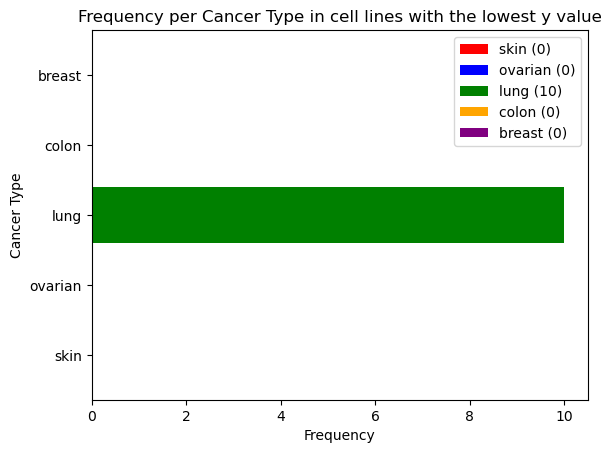

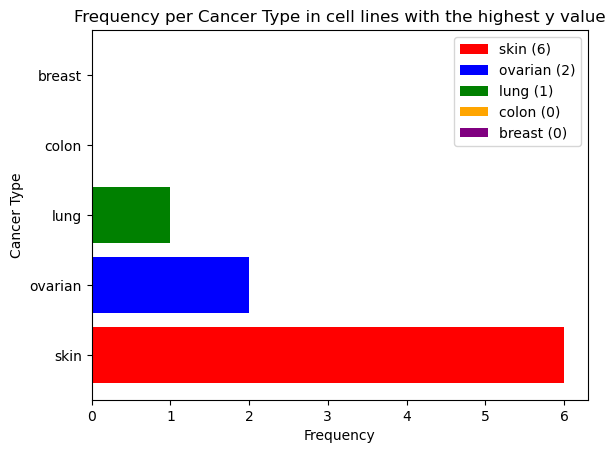

In [18]:
fig, ax = plt.subplots()

for cancer_type, color in zip(dataset['Cancer_Type'].unique(), ['red', 'blue', 'green', 'orange', 'purple']):
    df_cancer_type = df_bottom_10[df_bottom_10['Cancer_Type'] == cancer_type]

    freq = len(df_cancer_type)
    ax.barh(cancer_type, freq, color=color, label=f'{cancer_type} ({freq})')

ax.set_xlabel('Frequency')
ax.set_ylabel('Cancer Type')
ax.set_title('Frequency per Cancer Type in cell lines with the lowest y value')

# add legend
ax.legend()

# show the plot
plt.show()

fig, ax = plt.subplots()

for cancer_type, color in zip(dataset['Cancer_Type'].unique(), ['red', 'blue', 'green', 'orange', 'purple']):
    df_cancer_type = df_top_10[df_top_10['Cancer_Type'] == cancer_type]

    freq = len(df_cancer_type)
    ax.barh(cancer_type, freq, color=color, label=f'{cancer_type} ({freq})')

ax.set_xlabel('Frequency')
ax.set_ylabel('Cancer Type')
ax.set_title('Frequency per Cancer Type in cell lines with the highest y value')

# add legend
ax.legend()

# show the plot
plt.show()

Here we tried to find out whether the ability of two drugs to synergize could be related to the type of cancer tissue being analyzed. We found that when we analyzed the 10 lowest Y values, where synergy is null, they all correspond to the lung. Without more information, we can't draw an immediate conclusion, but it may show how difficult it is to find a good synergy between drugs in this type of pathology. However, when we analyze the 10 highest Y values, we also see the presence of “lung” tissue. This leads us to conclude that, as expected, synergy does not only have to do with the type of tissue, but also with the drugs combined.

In view of this, we decided to explore the average y values for each type of cancer (below), where we found that the lowest values are associated with prostate and lung cancers. However, given the results obtained, we can't draw any conclusions because when we consider the standard deviation, we see that all types of cancer are practically in the same range of average Y values.

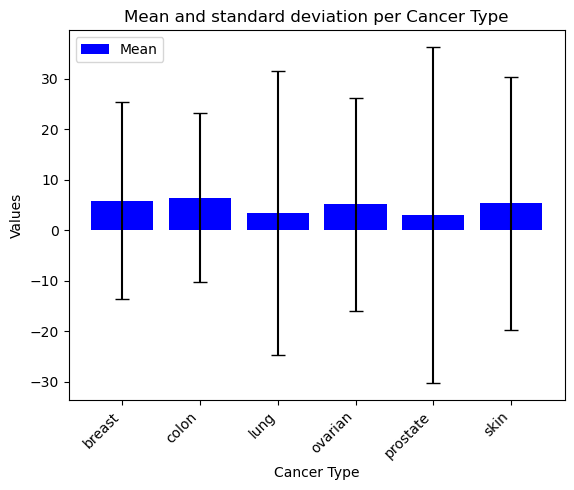

In [19]:
cancer_type_statistics = ordered_by_y.groupby('Cancer_Type')['Y'].agg(['mean', 'std']).reset_index()

cancer_type_statistics = cancer_type_statistics.rename(columns={'mean': 'Mean_Y', 'std': 'Std_Y'})

fig, ax = plt.subplots()

ax.bar(cancer_type_statistics['Cancer_Type'], cancer_type_statistics['Mean_Y'], color='blue', label='Mean', yerr=cancer_type_statistics['Std_Y'], capsize=5)

ax.set_xlabel('Cancer Type')
ax.set_ylabel('Values')
ax.set_title('Mean and standard deviation per Cancer Type')

# add legend
ax.legend()

plt.xticks(rotation=45, ha='right')

# show the plot
plt.show()

**heatmap**:
code calculates the average of the Y variable for each combination of two drugs and displays the results in a heatmap, making it easier to analyze the correlation between drugs based on the average of Y.

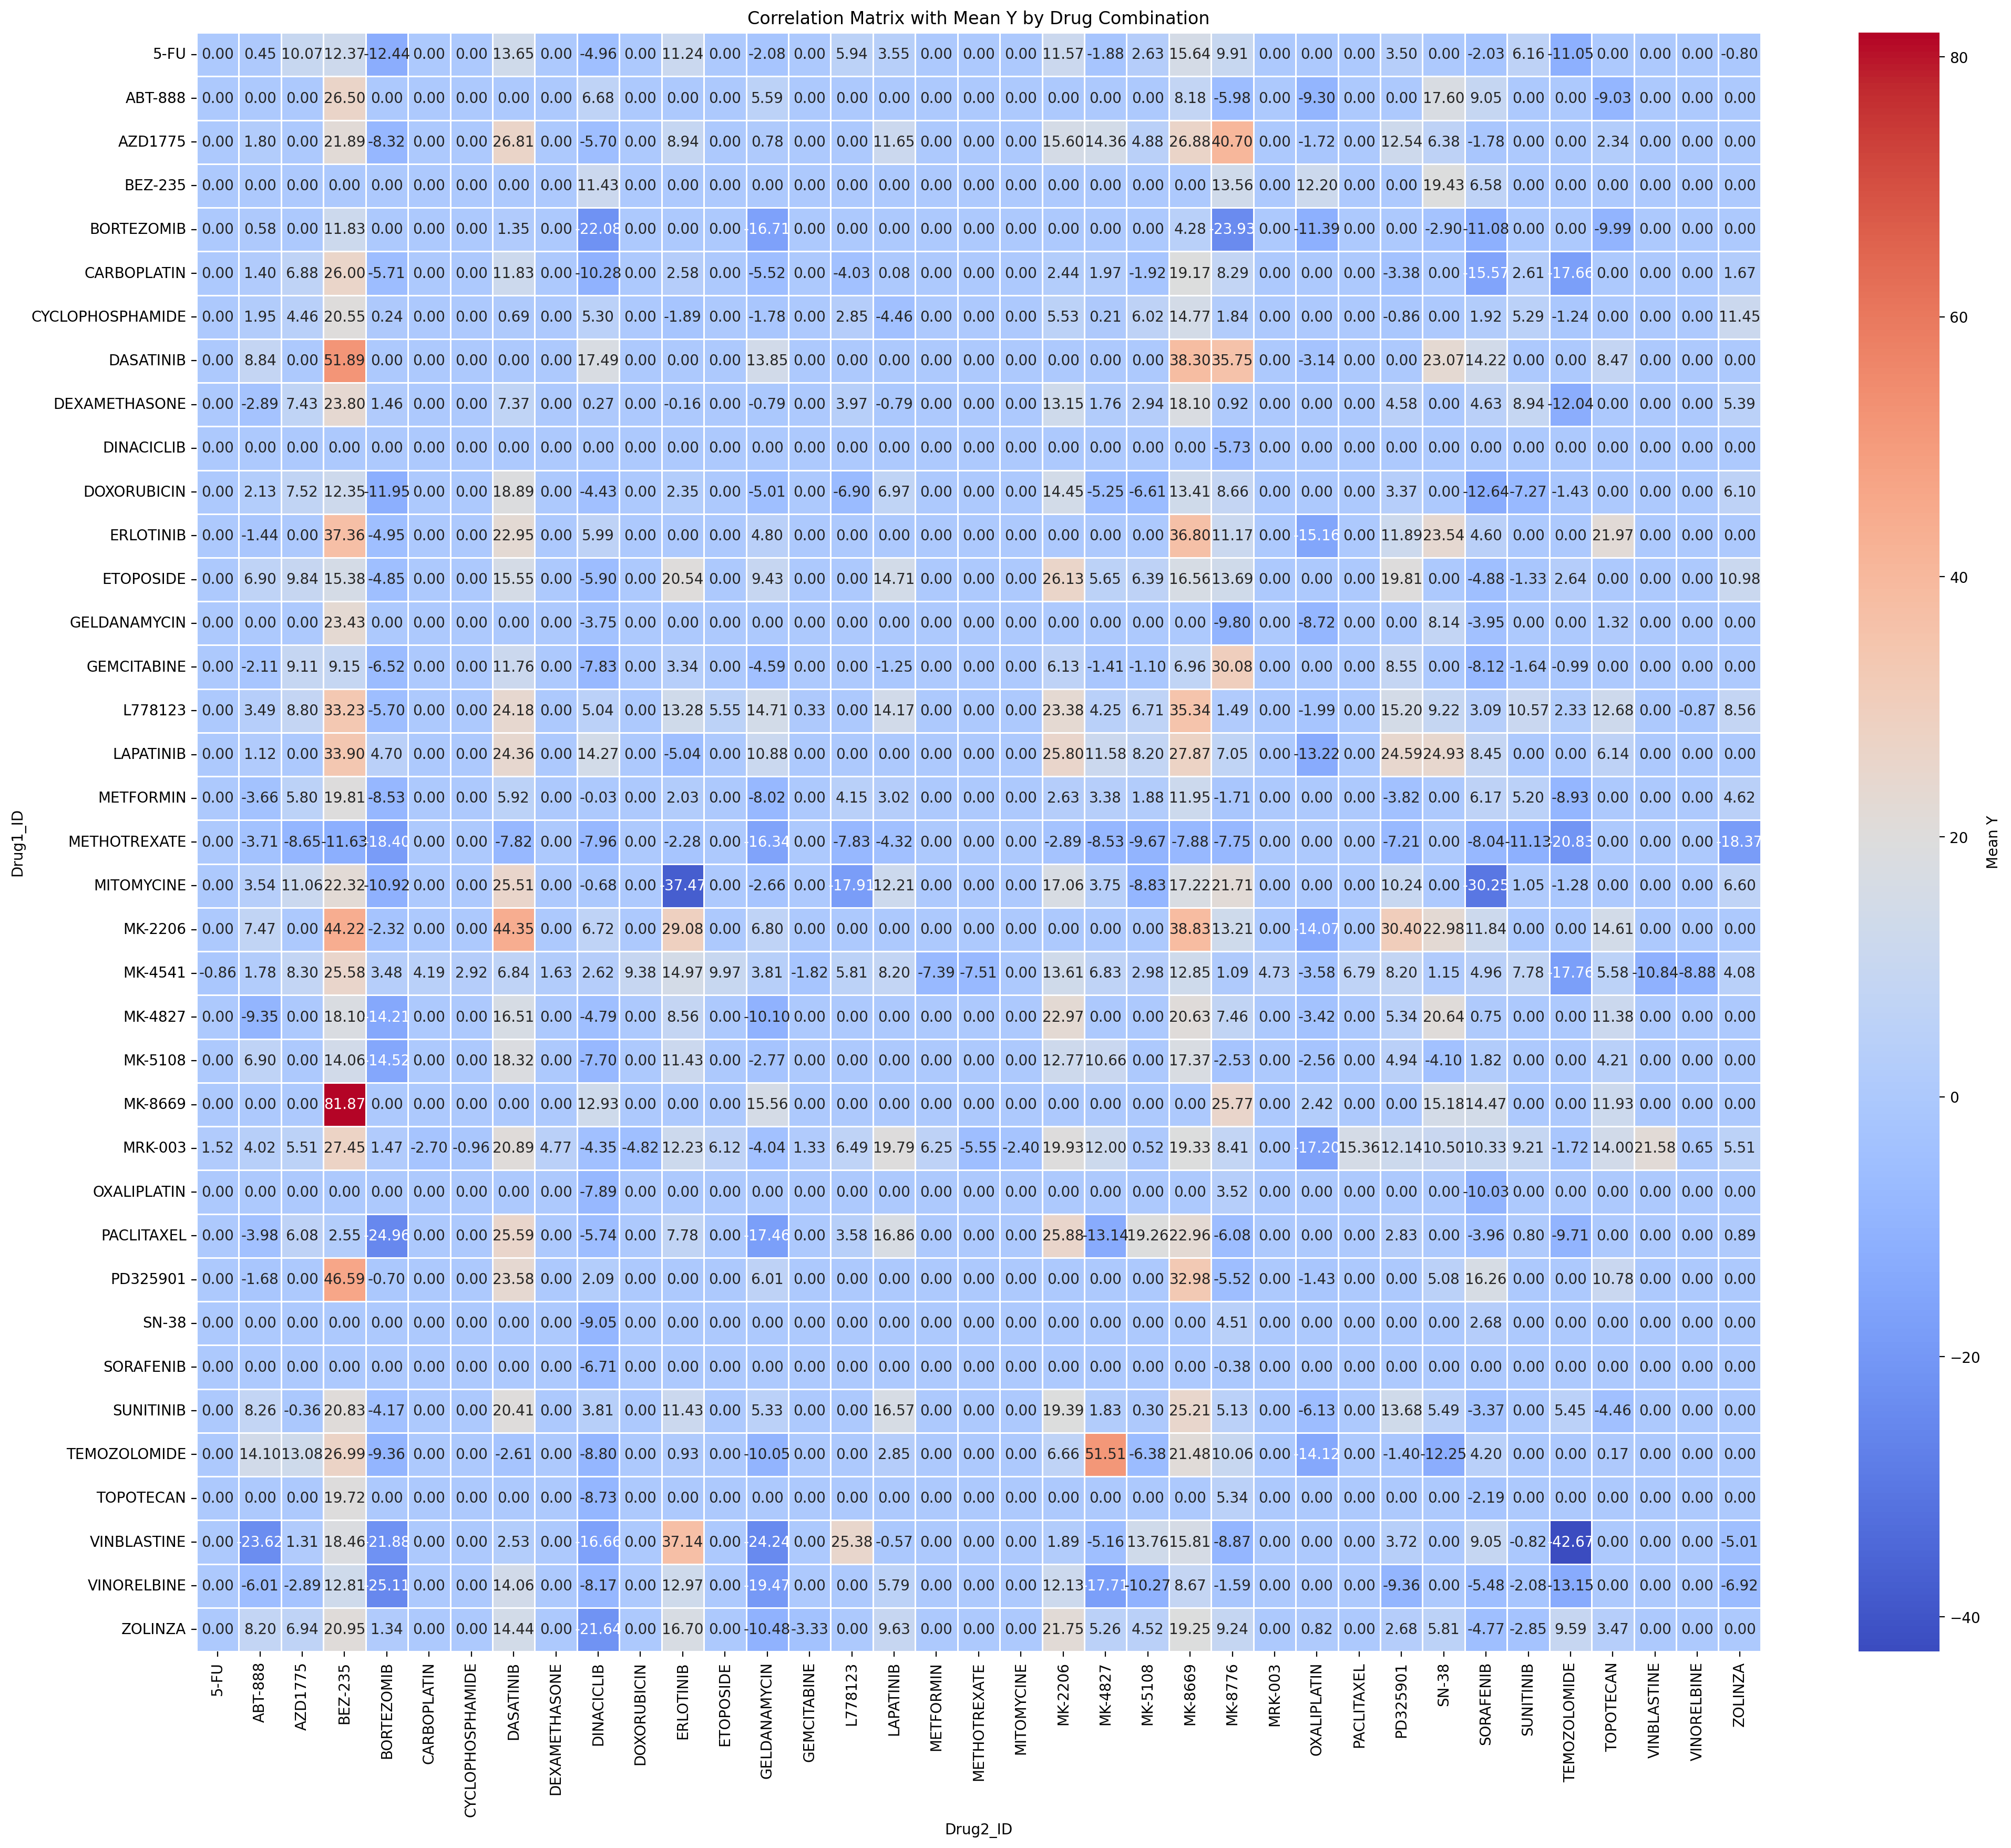

In [20]:
# calculate the mean of Y for each combination of drugs
mean_per_combination = dataset.groupby(['Drug1_ID', 'Drug2_ID'])['Y'].mean().reset_index()

# create the matrix of means for each drug combination
mean_matrix = mean_per_combination.pivot(index='Drug1_ID', columns='Drug2_ID', values='Y').fillna(0)

# set the size of the plot for better visualization
plt.figure(figsize=(24, 20), dpi=200)

# generate the heatmap
sns.heatmap(mean_matrix, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Y'}, linewidths=0.5)

# add titles and labels
plt.xlabel('Drug2_ID')
plt.ylabel('Drug1_ID')
plt.title('Correlation Matrix with Mean Y by Drug Combination')

# show the plot
plt.show()

The bibliographical research carried out allowed us to obtain information not initially described, that certain sets of drugs were not combined in this experiment and, as such, a value of y = 0 appears. The graph below shows a zone from the drug 5-FU to the drug VINORELBINE where the correlation values are all zero, which confirms this information


**Looking at the heatmap visualization, we can make the following conclusions:**

**Patterns of effective drug combinations:**

Cells with higher values, which appear in shades of red, indicate drug combinations with high Y averages, which may suggest that these combinations are more effective.

For example, combinations involving certain drugs, such as MK-451, MK-452, among others, seem to have relatively higher values, which may indicate synergistic or effective interactions between these drugs.

**Ineffective or low-efficacy combinations:**

Cells with lower values, which appear in shades of blue, indicate combinations with low Y averages, which may suggest that these combinations are less effective or have no significant effect.
A clear example of low efficacy can be seen in combinations of 5-FU with other drugs, such as MK-0633, which has very low values, possibly indicating that this combination has no relevant impact.

**Diversity of results:**

The wide variation in colors (from blue to red) indicates that there are different levels of efficacy between drug combinations, with some being more promising than others.
Some combinations may have a high Y value for one drug, but low for another, showing that the effect is specific to each combination.

**Regional patterns:**

The graph may show regional groupings of drugs with similar interactions, with areas sharing similar colors, which may indicate a trend in how certain groups of drugs interact with each other.

**Possible outliers:**

The presence of very high or very low values in some cells (as in the case of MK-8669 with MK-0633) may be of interest for further analysis, as these combinations may behave atypically in relation to the rest of the data.

**Overall conclusion:**

The heatmap visualization facilitates the identification of the most and least effective drug combinations, allowing a quick and intuitive analysis of the interaction patterns between drugs based on the average of Y. This makes it possible to direct future research towards the most promising combinations or to investigate the causes of low efficacy in certain interactions.

## Data preprocessing

### Train dataset preprocessing

Remove outliers

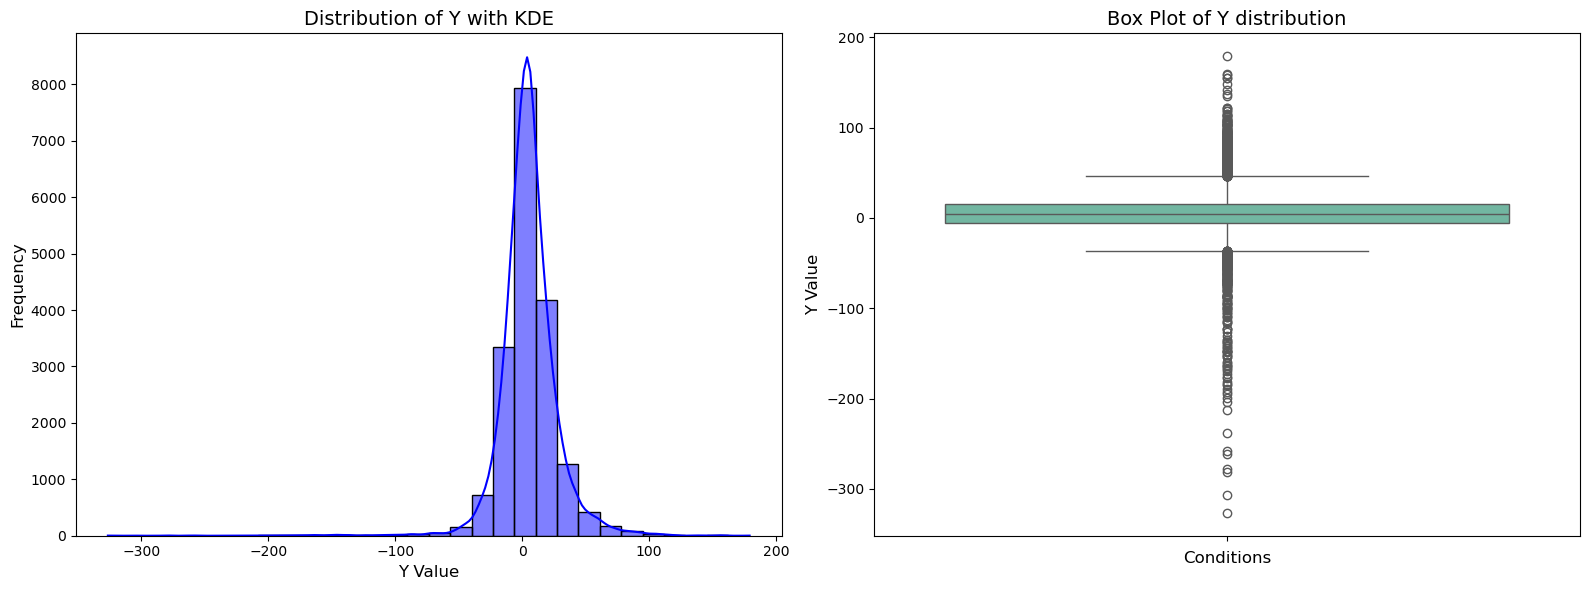

In [21]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# histogram with kde
sns.histplot(train_data['Y'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title("Distribution of Y with KDE", fontsize=14)
axes[0].set_xlabel("Y Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# box plot
sns.boxplot(y=train_data['Y'], palette='Set2', ax=axes[1])
axes[1].set_title("Box Plot of Y distribution", fontsize=14)
axes[1].set_xlabel("Conditions", fontsize=12)
axes[1].set_ylabel("Y Value", fontsize=12)

# adjust layout for better spacing
plt.tight_layout()

# show the plots
plt.show()


In [22]:
# quantitative identification of outliers (using iqr)
q1_train = train_data['Y'].quantile(0.25)
q3_train = train_data['Y'].quantile(0.75)
iqr_train = q3_train - q1_train

# defining the limits to identify outliers
lower_bound_train = q1_train - 1.5 * iqr_train
upper_bound_train = q3_train + 1.5 * iqr_train

# identifying outliers
outliers_train = train_data[(train_data['Y'] < lower_bound_train) | (train_data['Y'] > upper_bound_train)]
print("Number of outliers:", len(outliers_train))

# removing outliers
train_data_wo_outliers = train_data[~train_data.index.isin(outliers_train.index)]

# confirming removal of outliers
remaining_outliers_train = train_data_wo_outliers[(train_data_wo_outliers['Y'] < lower_bound_train) | (train_data_wo_outliers['Y'] > upper_bound_train)]
print("Number of outliers after removal:", len(remaining_outliers_train))

print(train_data.shape)
print(train_data_wo_outliers.shape)

Number of outliers: 1017
Number of outliers after removal: 0
(18442, 7)
(17425, 7)


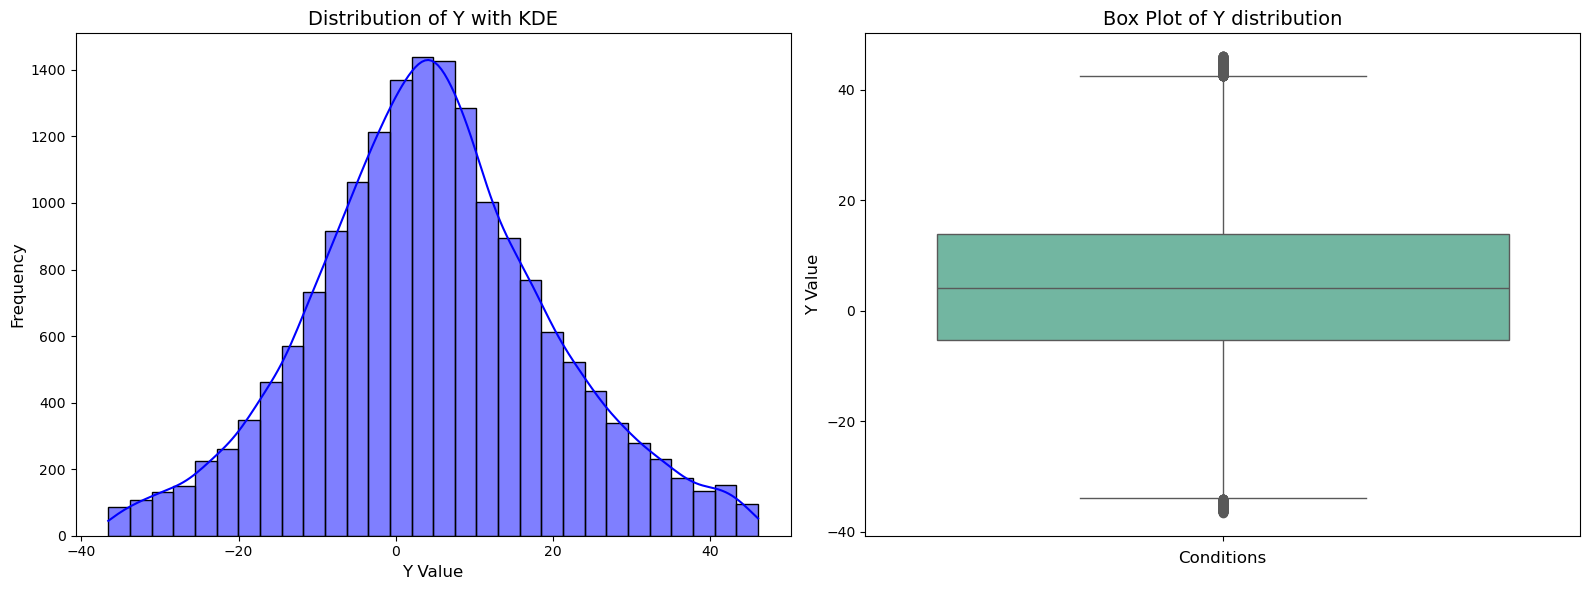

In [23]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# histogram with kde
sns.histplot(train_data_wo_outliers['Y'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title("Distribution of Y with KDE", fontsize=14)
axes[0].set_xlabel("Y Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# box plot
sns.boxplot(y=train_data_wo_outliers['Y'], palette='Set2', ax=axes[1])
axes[1].set_title("Box Plot of Y distribution", fontsize=14)
axes[1].set_xlabel("Conditions", fontsize=12)
axes[1].set_ylabel("Y Value", fontsize=12)

# adjust layout for better spacing
plt.tight_layout()

# show the plots
plt.show()


Create a dataset with the genomic features

In [ ]:
genomic_features_train = train_data_wo_outliers['Cell_Line']
genomic_features_train = pd.DataFrame(genomic_features_train.tolist(), columns=[f'Genomic_{i}' for i in range(len(genomic_features_train.iloc[0]))])
genomic_features_train.head()

In [22]:
# shape of the genomic features dataframe
print(genomic_features_train.shape)
# remove rows with nan values
genomic_features_train = genomic_features_train.dropna()

# as we can see, the shapes are the same so there were no nan values
print(genomic_features_train.shape)

# check if there are columns with nan values in the genomic features dataframe
print(genomic_features_train.isna().any().sum())

(17425, 8785)
(17425, 8785)
0


Standardize the data

In [23]:
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings

def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)
    
    # avoid errors with invalid molecules
    if mol is None:
        return None
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    
    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

In [24]:
# apply the function to the "Drug1" SMILES column
standardized_drug1_train = train_data_wo_outliers.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
standardized_drug1_train.head()

0    O=c1[nH]cc(F)c(=O)[nH]1
1    O=c1[nH]cc(F)c(=O)[nH]1
2    O=c1[nH]cc(F)c(=O)[nH]1
3    O=c1[nH]cc(F)c(=O)[nH]1
4    O=c1[nH]cc(F)c(=O)[nH]1
dtype: object

In [25]:
# apply the function to the "Drug2" SMILES column
standardized_drug2_train = train_data_wo_outliers.copy().apply(lambda x: standardize(x['Drug2']), axis=1)
standardized_drug2_train.head()

0    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4    CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
dtype: object

In [26]:
unique_drug1_train = list(train_data_wo_outliers['Drug1'].unique())
unique_drug1_id_train = list(train_data_wo_outliers['Drug1_ID'].unique())
unique_standardized_drug1_train = list(standardized_drug1_train.unique())

unique_drug2_train = list(train_data_wo_outliers['Drug2'].unique())
unique_drug2_id_train = list(train_data_wo_outliers['Drug2_ID'].unique())
unique_standardized_drug2_train = list(standardized_drug2_train.unique())

Unique Drug1 molecules


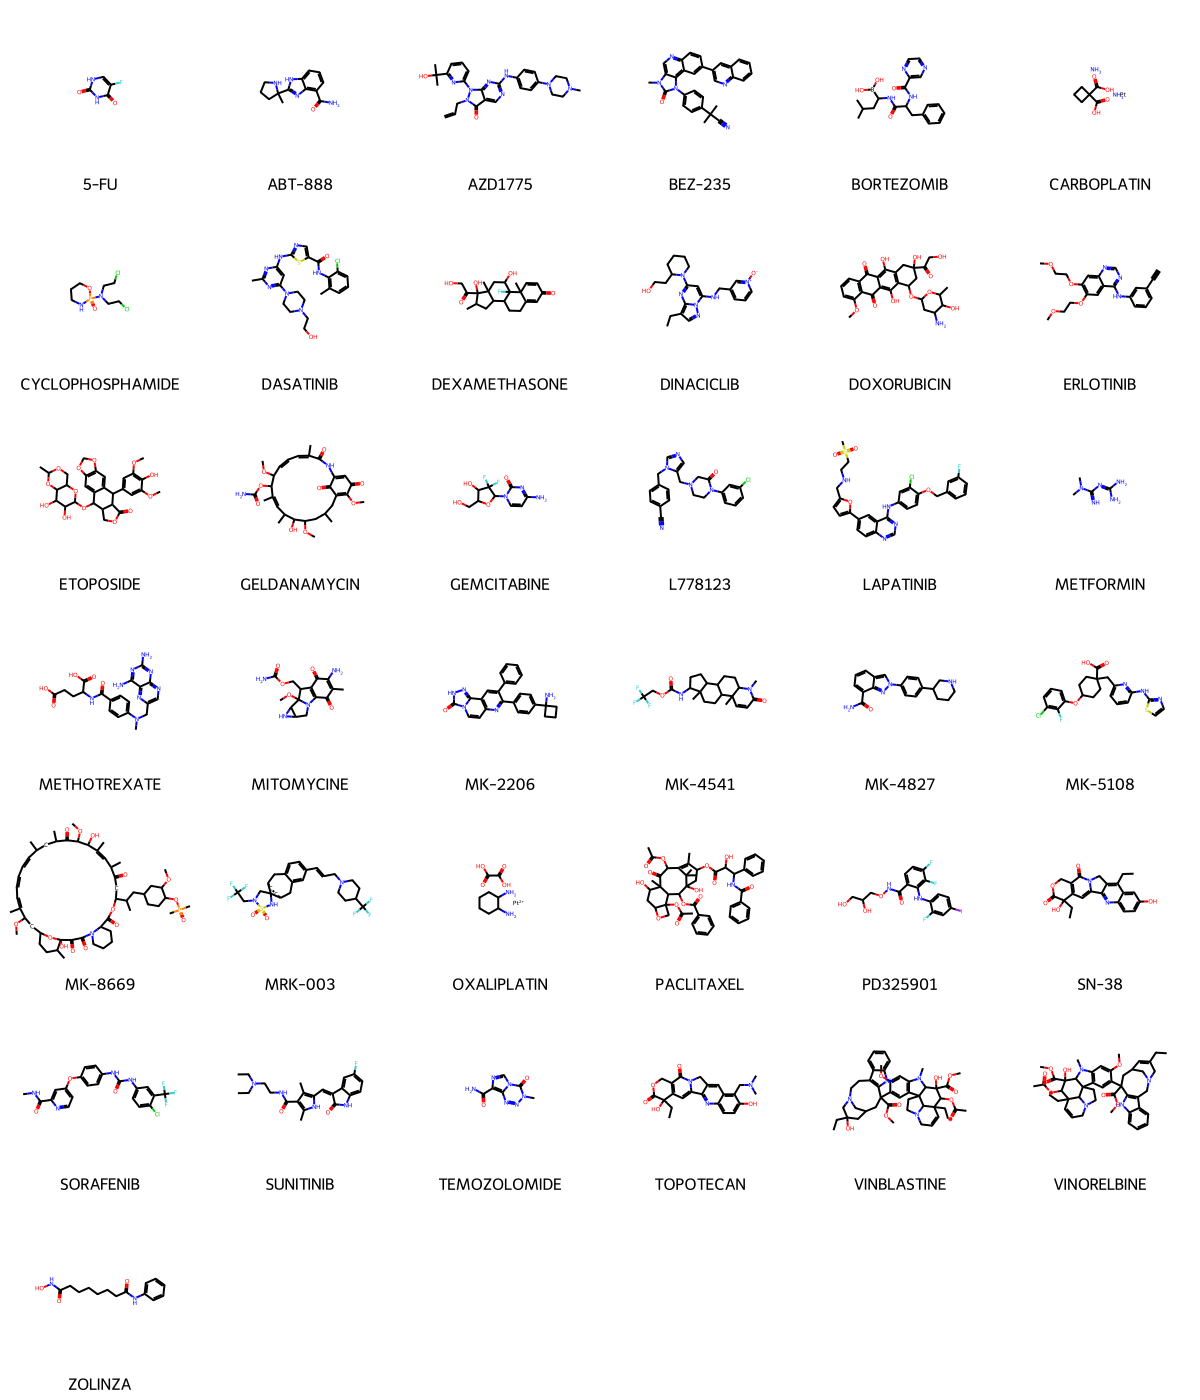

In [27]:
print("Unique Drug1 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug1_train], molsPerRow=6, legends=unique_drug1_id_train)

Unique Drug1 standardized molecules


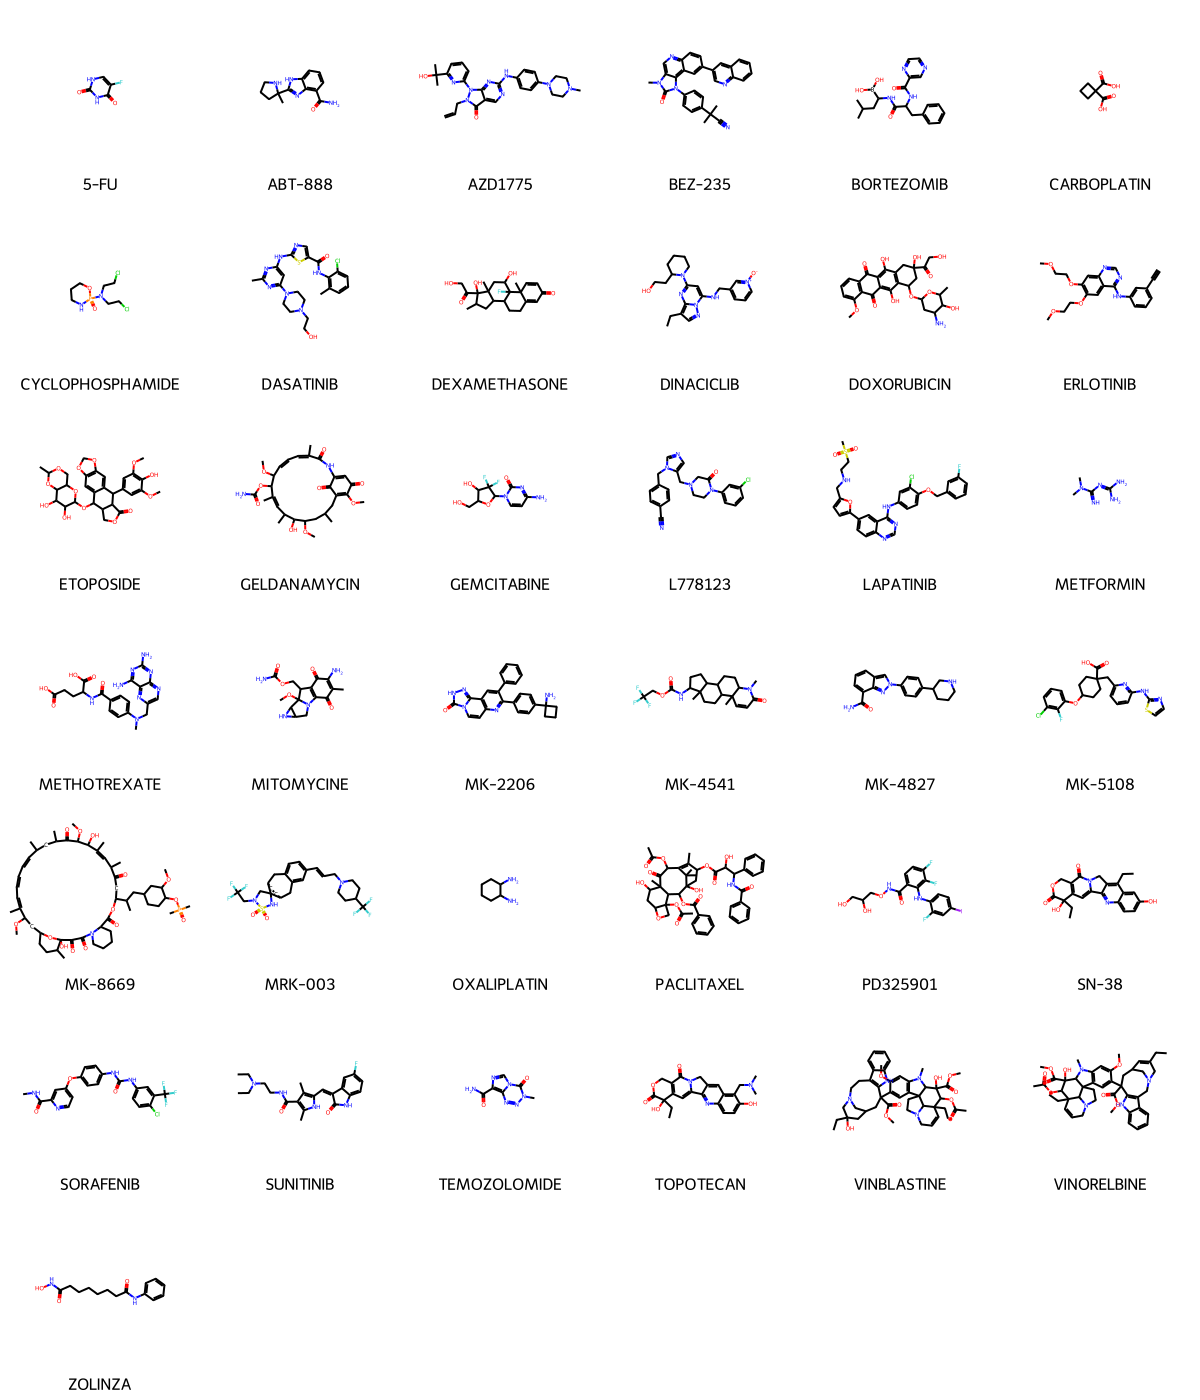

In [28]:
print("Unique Drug1 standardized molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smiles) for smiles in unique_standardized_drug1_train], molsPerRow=6, legends=unique_drug1_id_train)

Unique Drug2 molecules


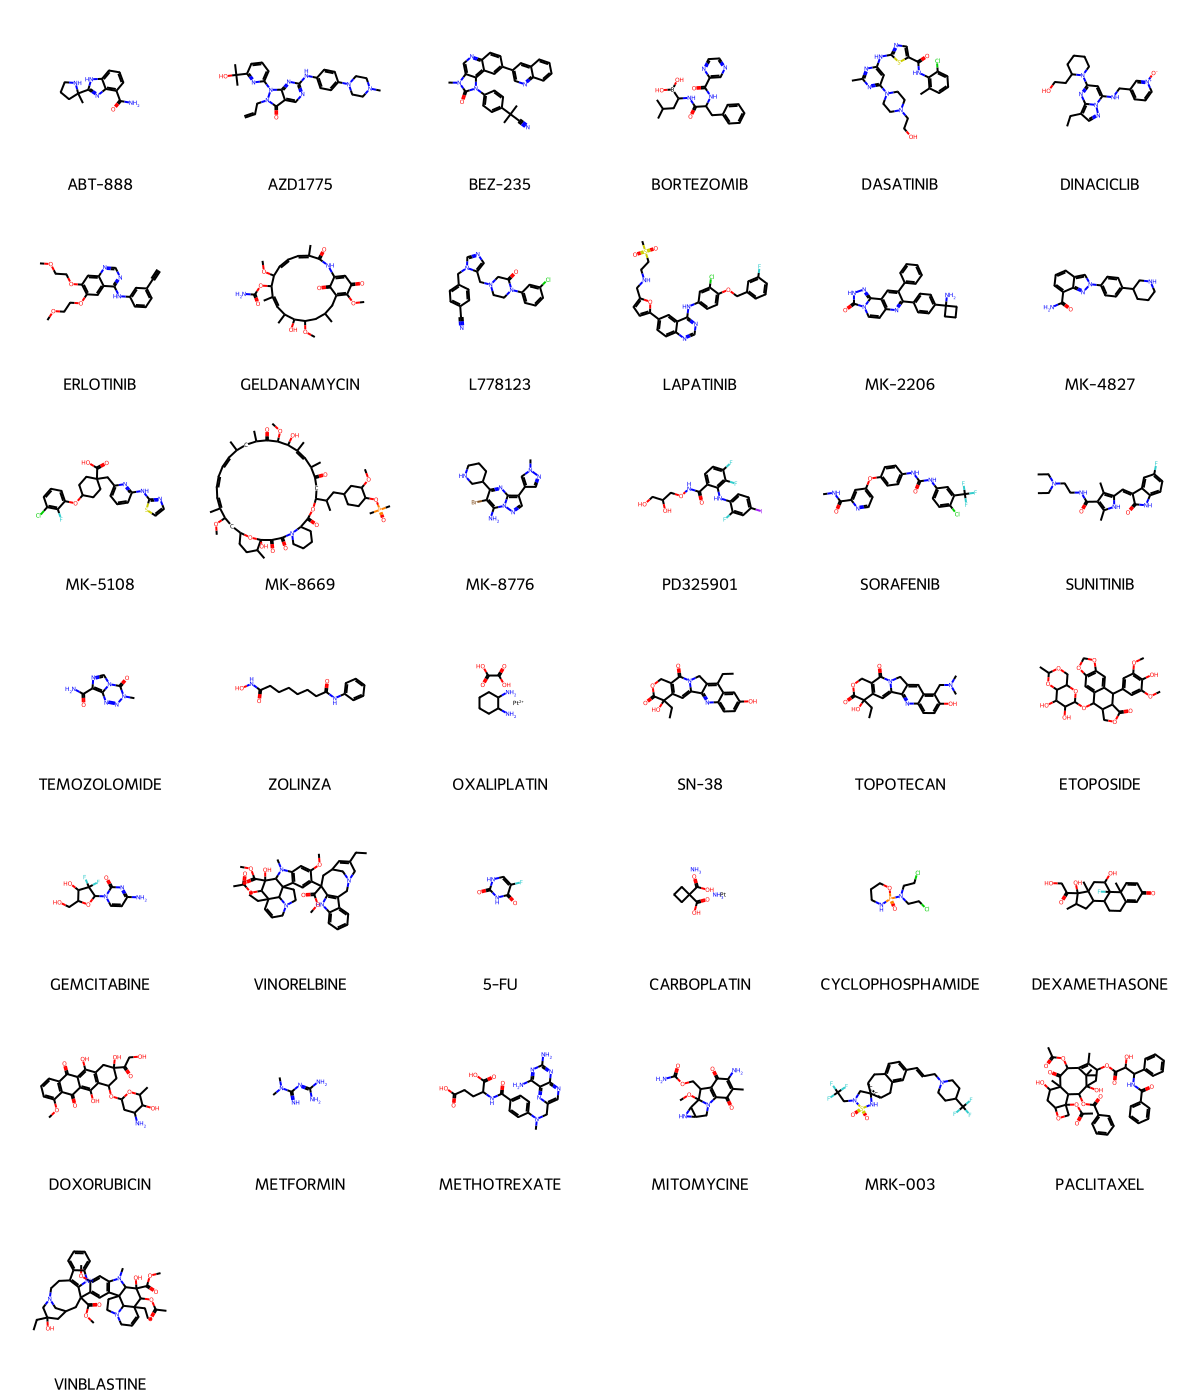

In [29]:
print("Unique Drug2 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug2_train], molsPerRow=6, legends=unique_drug2_id_train)

Unique Drug2 standardized molecules


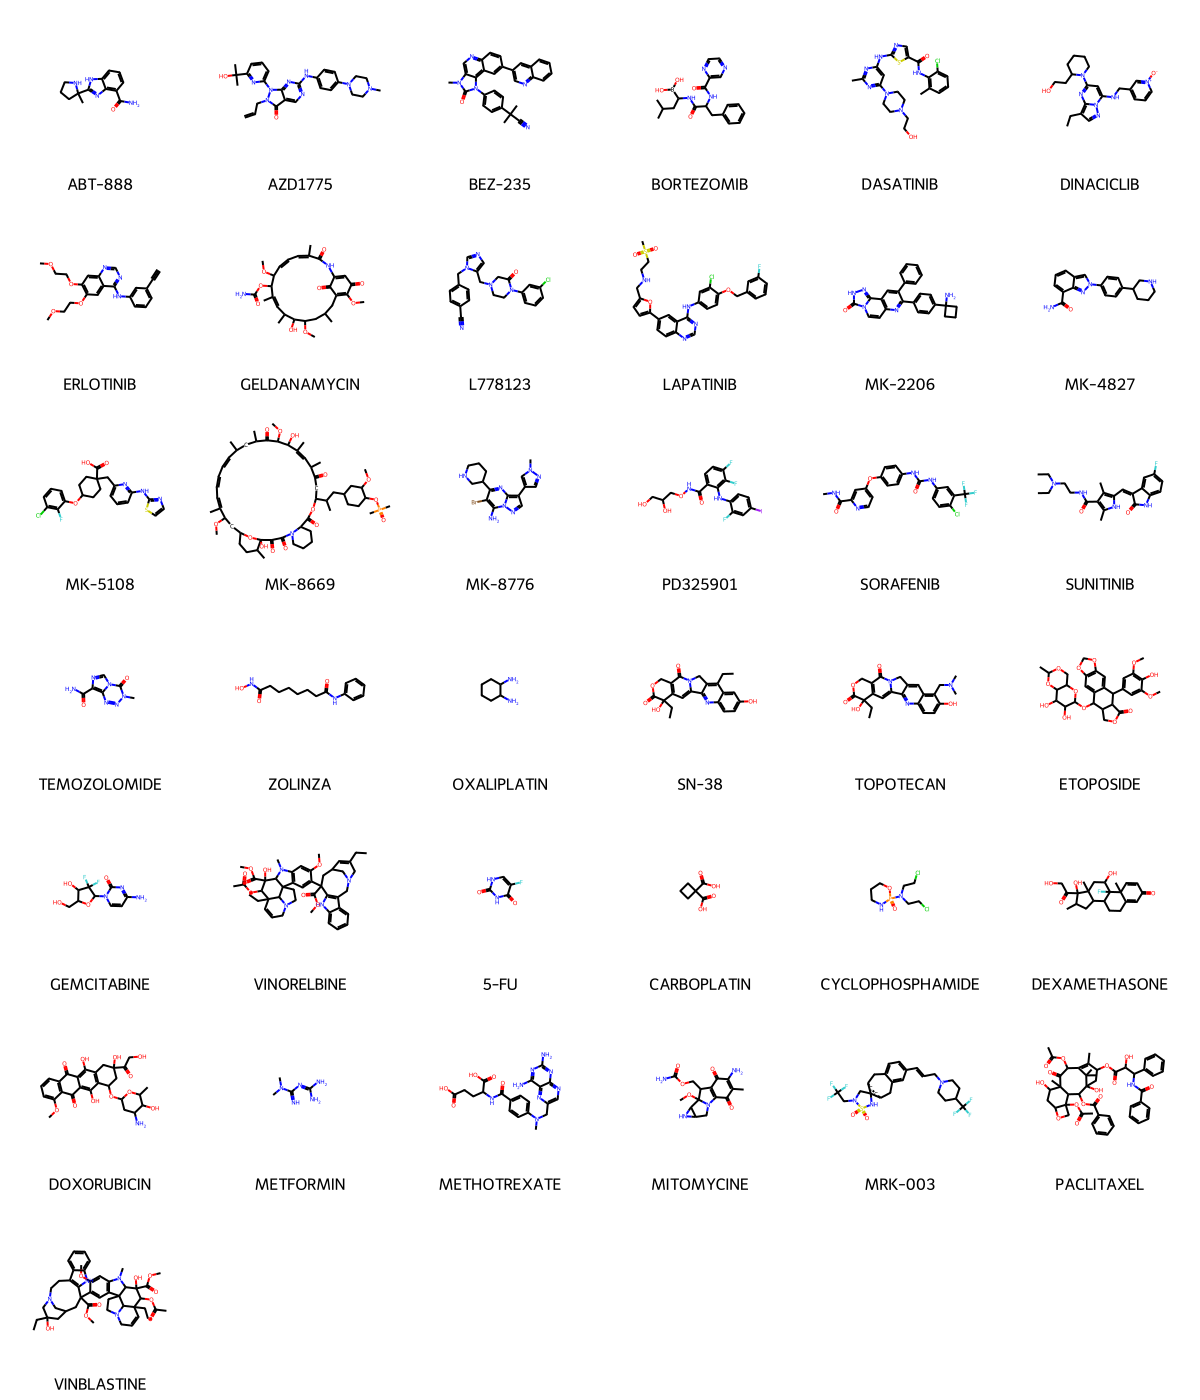

In [30]:
print("Unique Drug2 standardized molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smiles) for smiles in unique_standardized_drug2_train], molsPerRow=6, legends=unique_drug2_id_train)

Create features with RDKit

Create descriptors

In [31]:
# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan

In [32]:
# calculate descriptors for drug1
descriptors_drug1_train = standardized_drug1_train.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug1_train = pd.DataFrame(descriptors_drug1_train.values.tolist(), columns=[f'{x[0]}_drug1' for x in Descriptors._descList])
descriptors_drug1_train.head()

MaxAbsEStateIndex_drug1  MaxEStateIndex_drug1  MinAbsEStateIndex_drug1  \
0                11.984815             11.984815                 0.707037   
1                11.984815             11.984815                 0.707037   
2                11.984815             11.984815                 0.707037   
3                11.984815             11.984815                 0.707037   
4                11.984815             11.984815                 0.707037   

   MinEStateIndex_drug1  qed_drug1  SPS_drug1  MolWt_drug1  \
0             -1.001157   0.482565   9.444445   130.078003   
1             -1.001157   0.482565   9.444445   130.078003   
2             -1.001157   0.482565   9.444445   130.078003   
3             -1.001157   0.482565   9.444445   130.078003   
4             -1.001157   0.482565   9.444445   130.078003   

   HeavyAtomMolWt_drug1  ExactMolWt_drug1  NumValenceElectrons_drug1  ...  \
0            127.054001        130.017853                       48.0  ...   
1            127.054001        130.017853                       48.0  ...   
2            127.054001        130.017853                       48.0  ...   
3            127.054001        130.017853                       48.0  ...   
4            127.054001        130.017853                       48.0  ...   

   fr_sulfide_drug1  fr_sulfonamd_drug1  fr_sulfone_drug1  \
0               0.0                 0.0               0.0   
1               0.0                 0.0               0.0   
2               0.0                 0.0               0.0   
3               0.0                 0.0               0.0   
4               0.0                 0.0               0.0   

   fr_term_acetylene_drug1  fr_tetrazole_drug1  fr_thiazole_drug1  \
0                      0.0                 0.0                0.0   
1                      0.0                 0.0                0.0   
2                      0.0                 0.0                0.0   
3                      0.0                 0.0                0.0   
4                      0.0                 0.0                0.0   

   fr_thiocyan_drug1  fr_thiophene_drug1  fr_unbrch_alkane_drug1  \
0                0.0                 0.0                     0.0   
1                0.0                 0.0                     0.0   
2                0.0                 0.0                     0.0   
3                0.0                 0.0                     0.0   
4                0.0                 0.0                     0.0   

   fr_urea_drug1  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 210 columns]

In [33]:
# calculate descriptors for drug2
descriptors_drug2_train = standardized_drug2_train.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug2_train = pd.DataFrame(descriptors_drug2_train.values.tolist(), columns=[f'{x[0]}_drug2' for x in Descriptors._descList])
descriptors_drug2_train.head()

MaxAbsEStateIndex_drug2  MaxEStateIndex_drug2  MinAbsEStateIndex_drug2  \
0                11.377987             11.377987                 0.131016   
1                11.377987             11.377987                 0.131016   
2                11.377987             11.377987                 0.131016   
3                11.377987             11.377987                 0.131016   
4                11.377987             11.377987                 0.131016   

   MinEStateIndex_drug2  qed_drug2  SPS_drug2  MolWt_drug2  \
0             -0.441496   0.743254  23.611111   244.298004   
1             -0.441496   0.743254  23.611111   244.298004   
2             -0.441496   0.743254  23.611111   244.298004   
3             -0.441496   0.743254  23.611111   244.298004   
4             -0.441496   0.743254  23.611111   244.298004   

   HeavyAtomMolWt_drug2  ExactMolWt_drug2  NumValenceElectrons_drug2  ...  \
0            228.169998        244.132416                       94.0  ...   
1            228.169998        244.132416                       94.0  ...   
2            228.169998        244.132416                       94.0  ...   
3            228.169998        244.132416                       94.0  ...   
4            228.169998        244.132416                       94.0  ...   

   fr_sulfide_drug2  fr_sulfonamd_drug2  fr_sulfone_drug2  \
0               0.0                 0.0               0.0   
1               0.0                 0.0               0.0   
2               0.0                 0.0               0.0   
3               0.0                 0.0               0.0   
4               0.0                 0.0               0.0   

   fr_term_acetylene_drug2  fr_tetrazole_drug2  fr_thiazole_drug2  \
0                      0.0                 0.0                0.0   
1                      0.0                 0.0                0.0   
2                      0.0                 0.0                0.0   
3                      0.0                 0.0                0.0   
4                      0.0                 0.0                0.0   

   fr_thiocyan_drug2  fr_thiophene_drug2  fr_unbrch_alkane_drug2  \
0                0.0                 0.0                     0.0   
1                0.0                 0.0                     0.0   
2                0.0                 0.0                     0.0   
3                0.0                 0.0                     0.0   
4                0.0                 0.0                     0.0   

   fr_urea_drug2  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 210 columns]

Create morgan fingerprints

In [34]:
# Morgan fingerprints
def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

In [35]:
# calculate morgan fingerprints for drug1
morgan_fingerprints_drug1_train = standardized_drug1_train.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug1_train = pd.DataFrame(morgan_fingerprints_drug1_train.values.tolist(), columns=[f'Morgan_{i}_drug1' for i in range(1024)])
morgan_fingerprints_drug1_train.head()

Morgan_0_drug1  Morgan_1_drug1  Morgan_2_drug1  Morgan_3_drug1  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Morgan_4_drug1  Morgan_5_drug1  Morgan_6_drug1  Morgan_7_drug1  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Morgan_8_drug1  Morgan_9_drug1  ...  Morgan_1014_drug1  Morgan_1015_drug1  \
0             0.0             0.0  ...                0.0                0.0   
1             0.0             0.0  ...                0.0                0.0   
2             0.0             0.0  ...                0.0                0.0   
3             0.0             0.0  ...                0.0                0.0   
4             0.0             0.0  ...                0.0                0.0   

   Morgan_1016_drug1  Morgan_1017_drug1  Morgan_1018_drug1  Morgan_1019_drug1  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1020_drug1  Morgan_1021_drug1  Morgan_1022_drug1  Morgan_1023_drug1  
0                0.0                0.0                0.0                0.0  
1                0.0                0.0                0.0                0.0  
2                0.0                0.0                0.0                0.0  
3                0.0                0.0                0.0                0.0  
4                0.0                0.0                0.0                0.0  

[5 rows x 1024 columns]

In [36]:
# calculate morgan fingerprints for drug2
morgan_fingerprints_drug2_train = standardized_drug2_train.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug2_train = pd.DataFrame(morgan_fingerprints_drug2_train.values.tolist(), columns=[f'Morgan_{i}_drug2' for i in range(1024)])
morgan_fingerprints_drug2_train.head()

Morgan_0_drug2  Morgan_1_drug2  Morgan_2_drug2  Morgan_3_drug2  \
0             0.0             0.0             0.0             1.0   
1             0.0             0.0             0.0             1.0   
2             0.0             0.0             0.0             1.0   
3             0.0             0.0             0.0             1.0   
4             0.0             0.0             0.0             1.0   

   Morgan_4_drug2  Morgan_5_drug2  Morgan_6_drug2  Morgan_7_drug2  \
0             1.0             0.0             0.0             0.0   
1             1.0             0.0             0.0             0.0   
2             1.0             0.0             0.0             0.0   
3             1.0             0.0             0.0             0.0   
4             1.0             0.0             0.0             0.0   

   Morgan_8_drug2  Morgan_9_drug2  ...  Morgan_1014_drug2  Morgan_1015_drug2  \
0             0.0             0.0  ...                0.0                0.0   
1             0.0             0.0  ...                0.0                0.0   
2             0.0             0.0  ...                0.0                0.0   
3             0.0             0.0  ...                0.0                0.0   
4             0.0             0.0  ...                0.0                0.0   

   Morgan_1016_drug2  Morgan_1017_drug2  Morgan_1018_drug2  Morgan_1019_drug2  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1020_drug2  Morgan_1021_drug2  Morgan_1022_drug2  Morgan_1023_drug2  
0                0.0                0.0                0.0                0.0  
1                0.0                0.0                0.0                0.0  
2                0.0                0.0                0.0                0.0  
3                0.0                0.0                0.0                0.0  
4                0.0                0.0                0.0                0.0  

[5 rows x 1024 columns]

Data imputation

In [37]:
# shape of the drug1 dataframes
print(descriptors_drug1_train.shape, morgan_fingerprints_drug1_train.shape)
# remove rows where all values are nan
descriptors_drug1_train = descriptors_drug1_train.dropna(how='all')

# we do the same for morgan_fingerprints
morgan_fingerprints_drug1_train = morgan_fingerprints_drug1_train.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
print(descriptors_drug1_train.shape, morgan_fingerprints_drug1_train.shape)

# check if there are columns with nan values in the drug1 dataframes
print(descriptors_drug1_train.isna().any().sum(), morgan_fingerprints_drug1_train.isna().any().sum())

(17425, 210) (17425, 1024)
(17425, 210) (17425, 1024)
0 0


In [38]:
# shape of the drug2 dataframes
print(descriptors_drug2_train.shape, morgan_fingerprints_drug2_train.shape)
# remove rows where all values are nan
descriptors_drug2_train = descriptors_drug2_train.dropna(how='all')

# we do the same for morgan_fingerprints
morgan_fingerprints_drug2_train = morgan_fingerprints_drug2_train.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
print(descriptors_drug2_train.shape, morgan_fingerprints_drug2_train.shape)

# check if there are columns with nan values in the drug2 dataframes
print(descriptors_drug2_train.isna().any().sum(), morgan_fingerprints_drug2_train.isna().any().sum())

(17425, 210) (17425, 1024)


(17425, 210) (17425, 1024)
0 0


Data scalling

In [39]:
# scale features data with StandardScaler
scaler = StandardScaler()

In [40]:
# scale drug1 descriptors data
scaled_descriptors_drug1_train = scaler.fit_transform(descriptors_drug1_train)
scaled_descriptors_drug1_train

array([[-0.3512618 , -0.3512618 ,  3.6291735 , ...,  0.        ,
        -0.1998149 , -0.05828759],
       [-0.3512618 , -0.3512618 ,  3.6291735 , ...,  0.        ,
        -0.1998149 , -0.05828759],
       [-0.3512618 , -0.3512618 ,  3.6291735 , ...,  0.        ,
        -0.1998149 , -0.05828759],
       ...,
       [-0.54126215, -0.54126215, -0.7521172 , ...,  0.        ,
         5.0046315 , -0.05828759],
       [-0.54126215, -0.54126215, -0.7521172 , ...,  0.        ,
         5.0046315 , -0.05828759],
       [-0.54126215, -0.54126215, -0.7521172 , ...,  0.        ,
         5.0046315 , -0.05828759]], dtype=float32)

In [41]:
# scale drug2 descriptors data
scaled_descriptors_drug2_train = scaler.fit_transform(descriptors_drug2_train)
scaled_descriptors_drug2_train

array([[-0.2078421 , -0.2078421 , -0.2155469 , ...,  0.        ,
        -0.16758355, -0.25270984],
       [-0.2078421 , -0.2078421 , -0.2155469 , ...,  0.        ,
        -0.16758355, -0.25270984],
       [-0.2078421 , -0.2078421 , -0.2155469 , ...,  0.        ,
        -0.16758355, -0.25270984],
       ...,
       [ 0.5077154 ,  0.5077154 , -0.43232346, ...,  0.        ,
        -0.16758355, -0.25270984],
       [ 0.5077154 ,  0.5077154 , -0.43232346, ...,  0.        ,
        -0.16758355, -0.25270984],
       [ 0.5077154 ,  0.5077154 , -0.43232346, ...,  0.        ,
        -0.16758355, -0.25270984]], dtype=float32)

In [42]:
# scale genomic features data
scaled_genomic_features_train = scaler.fit_transform(genomic_features_train)
scaled_genomic_features_train

array([[ 5.20623076,  4.96615941,  5.20623076, ...,  0.69610795,
        -0.98274107, -0.35162747],
       [ 5.20623076,  4.96615941,  5.20623076, ...,  1.14567704,
        -1.07073049, -0.41289285],
       [ 5.20623076,  4.96615941,  5.20623076, ..., -0.42432107,
        -1.06563027, -0.99390363],
       ...,
       [-0.19207754, -0.20136285, -0.19207754, ..., -0.37517421,
        -0.07080667, -0.20391842],
       [-0.19207754, -0.20136285, -0.19207754, ..., -0.37517421,
        -0.07080667, -0.20391842],
       [-0.19207754, -0.20136285, -0.19207754, ..., -1.71293745,
        -0.71370338,  0.65502241]])

Feature selection

In [43]:
# select drug1 and drug2 descriptors with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

In [44]:
# select drug1 descriptors

# initial descriptors shape
print(f'{descriptors_drug1_train.shape[1]} initial descriptors')

# selected drug1 descriptors
selected_descriptors_drug1_train = selector.fit_transform(scaled_descriptors_drug1_train)
selected_columns = descriptors_drug1_train.columns[selector.get_support()]
print(selected_descriptors_drug1_train.shape, selected_columns)

# number of drug1 descriptors removed
print(f'{descriptors_drug1_train.shape[1] - selected_descriptors_drug1_train.shape[1]} drug1 descriptors removed')

# convert selected drug1 descriptors numpy array into a pandas dataframe
selected_descriptors_drug1_train = pd.DataFrame(selected_descriptors_drug1_train, columns=selected_columns) 
selected_descriptors_drug1_train.head()

210 initial descriptors
(17425, 173) Index(['MaxAbsEStateIndex_drug1', 'MaxEStateIndex_drug1',
       'MinAbsEStateIndex_drug1', 'MinEStateIndex_drug1', 'qed_drug1',
       'SPS_drug1', 'MolWt_drug1', 'HeavyAtomMolWt_drug1', 'ExactMolWt_drug1',
       'NumValenceElectrons_drug1',
       ...
       'fr_phenol_noOrthoHbond_drug1', 'fr_piperdine_drug1',
       'fr_piperzine_drug1', 'fr_priamide_drug1', 'fr_pyridine_drug1',
       'fr_sulfone_drug1', 'fr_term_acetylene_drug1', 'fr_thiazole_drug1',
       'fr_unbrch_alkane_drug1', 'fr_urea_drug1'],
      dtype='object', length=173)
37 drug1 descriptors removed


MaxAbsEStateIndex_drug1  MaxEStateIndex_drug1  MinAbsEStateIndex_drug1  \
0                -0.351262             -0.351262                 3.629174   
1                -0.351262             -0.351262                 3.629174   
2                -0.351262             -0.351262                 3.629174   
3                -0.351262             -0.351262                 3.629174   
4                -0.351262             -0.351262                 3.629174   

   MinEStateIndex_drug1  qed_drug1  SPS_drug1  MolWt_drug1  \
0               0.51876   0.125923  -1.188591    -1.550956   
1               0.51876   0.125923  -1.188591    -1.550956   
2               0.51876   0.125923  -1.188591    -1.550956   
3               0.51876   0.125923  -1.188591    -1.550956   
4               0.51876   0.125923  -1.188591    -1.550956   

   HeavyAtomMolWt_drug1  ExactMolWt_drug1  NumValenceElectrons_drug1  ...  \
0             -1.539251         -1.550381                  -1.521679  ...   
1             -1.539251         -1.550381                  -1.521679  ...   
2             -1.539251         -1.550381                  -1.521679  ...   
3             -1.539251         -1.550381                  -1.521679  ...   
4             -1.539251         -1.550381                  -1.521679  ...   

   fr_phenol_noOrthoHbond_drug1  fr_piperdine_drug1  fr_piperzine_drug1  \
0                     -0.276415           -0.399764           -0.376662   
1                     -0.276415           -0.399764           -0.376662   
2                     -0.276415           -0.399764           -0.376662   
3                     -0.276415           -0.399764           -0.376662   
4                     -0.276415           -0.399764           -0.376662   

   fr_priamide_drug1  fr_pyridine_drug1  fr_sulfone_drug1  \
0          -0.368672          -0.328746         -0.172055   
1          -0.368672          -0.328746         -0.172055   
2          -0.368672          -0.328746         -0.172055   
3          -0.368672          -0.328746         -0.172055   
4          -0.368672          -0.328746         -0.172055   

   fr_term_acetylene_drug1  fr_thiazole_drug1  fr_unbrch_alkane_drug1  \
0                -0.142753          -0.208358               -0.199815   
1                -0.142753          -0.208358               -0.199815   
2                -0.142753          -0.208358               -0.199815   
3                -0.142753          -0.208358               -0.199815   
4                -0.142753          -0.208358               -0.199815   

   fr_urea_drug1  
0      -0.058288  
1      -0.058288  
2      -0.058288  
3      -0.058288  
4      -0.058288  

[5 rows x 173 columns]

In [45]:
# select drug2 descriptors

# initial descriptors shape
print(f'{descriptors_drug1_train.shape[1]} initial descriptors')

# selected drug2 descriptors
selected_descriptors_drug2_train = selector.fit_transform(scaled_descriptors_drug2_train)
selected_columns = descriptors_drug2_train.columns[selector.get_support()]
print(selected_descriptors_drug2_train.shape, selected_columns)

# number of drug2 descriptors removed
print(f'{descriptors_drug2_train.shape[1] - selected_descriptors_drug2_train.shape[1]} drug2 descriptors removed')

# convert selected drug2 descriptors numpy array into a pandas dataframe
selected_descriptors_drug2_train = pd.DataFrame(selected_descriptors_drug2_train, columns=selected_columns) 
selected_descriptors_drug2_train.head()


210 initial descriptors
(17425, 172) Index(['MaxAbsEStateIndex_drug2', 'MaxEStateIndex_drug2',
       'MinAbsEStateIndex_drug2', 'MinEStateIndex_drug2', 'qed_drug2',
       'SPS_drug2', 'MolWt_drug2', 'HeavyAtomMolWt_drug2', 'ExactMolWt_drug2',
       'NumValenceElectrons_drug2',
       ...
       'fr_phenol_noOrthoHbond_drug2', 'fr_piperdine_drug2',
       'fr_piperzine_drug2', 'fr_priamide_drug2', 'fr_pyridine_drug2',
       'fr_sulfone_drug2', 'fr_term_acetylene_drug2', 'fr_thiazole_drug2',
       'fr_unbrch_alkane_drug2', 'fr_urea_drug2'],
      dtype='object', length=172)
38 drug2 descriptors removed


MaxAbsEStateIndex_drug2  MaxEStateIndex_drug2  MinAbsEStateIndex_drug2  \
0                -0.207842             -0.207842                -0.215547   
1                -0.207842             -0.207842                -0.215547   
2                -0.207842             -0.207842                -0.215547   
3                -0.207842             -0.207842                -0.215547   
4                -0.207842             -0.207842                -0.215547   

   MinEStateIndex_drug2  qed_drug2  SPS_drug2  MolWt_drug2  \
0               0.48423   1.681208   0.599567    -1.112019   
1               0.48423   1.681208   0.599567    -1.112019   
2               0.48423   1.681208   0.599567    -1.112019   
3               0.48423   1.681208   0.599567    -1.112019   
4               0.48423   1.681208   0.599567    -1.112019   

   HeavyAtomMolWt_drug2  ExactMolWt_drug2  NumValenceElectrons_drug2  ...  \
0             -1.147529         -1.111202                  -0.991363  ...   
1             -1.147529         -1.111202                  -0.991363  ...   
2             -1.147529         -1.111202                  -0.991363  ...   
3             -1.147529         -1.111202                  -0.991363  ...   
4             -1.147529         -1.111202                  -0.991363  ...   

   fr_phenol_noOrthoHbond_drug2  fr_piperdine_drug2  fr_piperzine_drug2  \
0                     -0.273689           -0.532373           -0.329226   
1                     -0.273689           -0.532373           -0.329226   
2                     -0.273689           -0.532373           -0.329226   
3                     -0.273689           -0.532373           -0.329226   
4                     -0.273689           -0.532373           -0.329226   

   fr_priamide_drug2  fr_pyridine_drug2  fr_sulfone_drug2  \
0           2.217841          -0.670716         -0.192559   
1           2.217841          -0.670716         -0.192559   
2           2.217841          -0.670716         -0.192559   
3           2.217841          -0.670716         -0.192559   
4           2.217841          -0.670716         -0.192559   

   fr_term_acetylene_drug2  fr_thiazole_drug2  fr_unbrch_alkane_drug2  \
0                -0.206401          -0.291653               -0.167584   
1                -0.206401          -0.291653               -0.167584   
2                -0.206401          -0.291653               -0.167584   
3                -0.206401          -0.291653               -0.167584   
4                -0.206401          -0.291653               -0.167584   

   fr_urea_drug2  
0       -0.25271  
1       -0.25271  
2       -0.25271  
3       -0.25271  
4       -0.25271  

[5 rows x 172 columns]

In [46]:
# select drug1 and drug2 morgan fingerprints with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

In [ ]:
# select drug1 morgan fingerprints

# initial morgan fingerprints shape
print(f'{morgan_fingerprints_drug1_train.shape[1]} initial morgan fingarprints')

# selected drug1 morgan fingerprints
selected_morgan_fingerprints_drug1_train = selector.fit_transform(morgan_fingerprints_drug1_train)
selected_columns = morgan_fingerprints_drug1_train.columns[selector.get_support()]
print(selected_morgan_fingerprints_drug1_train.shape, selected_columns)

# number of drug1 morgan fingerprints removed
print(f'{morgan_fingerprints_drug1_train.shape[1] - selected_morgan_fingerprints_drug1_train.shape[1]} drug1 morgan fingerprints removed')

# convert selected drug1 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug1_train = pd.DataFrame(selected_morgan_fingerprints_drug1_train, columns=selected_columns) 
selected_morgan_fingerprints_drug1_train.head()

1024 initial morgan fingarprints
(17425, 663) Index(['Morgan_0_drug1', 'Morgan_1_drug1', 'Morgan_3_drug1', 'Morgan_4_drug1',
       'Morgan_6_drug1', 'Morgan_7_drug1', 'Morgan_8_drug1', 'Morgan_9_drug1',
       'Morgan_11_drug1', 'Morgan_12_drug1',
       ...
       'Morgan_1008_drug1', 'Morgan_1009_drug1', 'Morgan_1010_drug1',
       'Morgan_1011_drug1', 'Morgan_1014_drug1', 'Morgan_1017_drug1',
       'Morgan_1018_drug1', 'Morgan_1019_drug1', 'Morgan_1020_drug1',
       'Morgan_1022_drug1'],
      dtype='object', length=663)
361 drug1 morgan fingerprints removed


Morgan_0_drug1  Morgan_1_drug1  Morgan_3_drug1  Morgan_4_drug1  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Morgan_6_drug1  Morgan_7_drug1  Morgan_8_drug1  Morgan_9_drug1  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   Morgan_11_drug1  Morgan_12_drug1  ...  Morgan_1008_drug1  \
0              0.0              0.0  ...                1.0   
1              0.0              0.0  ...                1.0   
2              0.0              0.0  ...                1.0   
3              0.0              0.0  ...                1.0   
4              0.0              0.0  ...                1.0   

   Morgan_1009_drug1  Morgan_1010_drug1  Morgan_1011_drug1  Morgan_1014_drug1  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1017_drug1  Morgan_1018_drug1  Morgan_1019_drug1  Morgan_1020_drug1  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1022_drug1  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 663 columns]

In [48]:
# select drug2 morgan fingerprints

# initial morgan fingerprints shape
print(f'{morgan_fingerprints_drug1_train.shape[1]} initial morgan fingarprints')

# selected drug2 morgan fingerprints
selected_morgan_fingerprints_drug2_train = selector.fit_transform(morgan_fingerprints_drug2_train)
selected_columns = morgan_fingerprints_drug2_train.columns[selector.get_support()]
print(selected_morgan_fingerprints_drug2_train.shape, selected_columns)

# number of drug2 morgan fingerprints removed
print(f'{morgan_fingerprints_drug2_train.shape[1] - selected_morgan_fingerprints_drug2_train.shape[1]} drug2 morgan fingerprints removed')

# convert selected drug2 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug2_train = pd.DataFrame(selected_morgan_fingerprints_drug2_train, columns=selected_columns) 
selected_morgan_fingerprints_drug2_train.head()

1024 initial morgan fingarprints
(17425, 549) Index(['Morgan_1_drug2', 'Morgan_3_drug2', 'Morgan_4_drug2', 'Morgan_6_drug2',
       'Morgan_7_drug2', 'Morgan_8_drug2', 'Morgan_9_drug2', 'Morgan_11_drug2',
       'Morgan_12_drug2', 'Morgan_13_drug2',
       ...
       'Morgan_1003_drug2', 'Morgan_1004_drug2', 'Morgan_1005_drug2',
       'Morgan_1009_drug2', 'Morgan_1010_drug2', 'Morgan_1011_drug2',
       'Morgan_1014_drug2', 'Morgan_1017_drug2', 'Morgan_1018_drug2',
       'Morgan_1019_drug2'],
      dtype='object', length=549)
475 drug2 morgan fingerprints removed


Morgan_1_drug2  Morgan_3_drug2  Morgan_4_drug2  Morgan_6_drug2  \
0             0.0             1.0             1.0             0.0   
1             0.0             1.0             1.0             0.0   
2             0.0             1.0             1.0             0.0   
3             0.0             1.0             1.0             0.0   
4             0.0             1.0             1.0             0.0   

   Morgan_7_drug2  Morgan_8_drug2  Morgan_9_drug2  Morgan_11_drug2  \
0             0.0             0.0             0.0              0.0   
1             0.0             0.0             0.0              0.0   
2             0.0             0.0             0.0              0.0   
3             0.0             0.0             0.0              0.0   
4             0.0             0.0             0.0              0.0   

   Morgan_12_drug2  Morgan_13_drug2  ...  Morgan_1003_drug2  \
0              0.0              0.0  ...                0.0   
1              0.0              0.0  ...                0.0   
2              0.0              0.0  ...                0.0   
3              0.0              0.0  ...                0.0   
4              0.0              0.0  ...                0.0   

   Morgan_1004_drug2  Morgan_1005_drug2  Morgan_1009_drug2  Morgan_1010_drug2  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1011_drug2  Morgan_1014_drug2  Morgan_1017_drug2  Morgan_1018_drug2  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1019_drug2  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 549 columns]

In [49]:
# select genomic features with variance > 0.01
selector = VarianceThreshold(threshold=0.01)

# initial genomic features shape
print(f'{genomic_features_train.shape[1]} initial genomic features')

# selected genomic features
selected_genomic_features_train = selector.fit_transform(scaled_genomic_features_train)
selected_columns = genomic_features_train.columns[selector.get_support()] 
print(selected_genomic_features_train.shape, selected_columns)

# number of genomic features removed
print(f'{genomic_features_train.shape[1] - selected_genomic_features_train.shape[1]} genomic features removed')

# convert selected genomic features numpy array into a pandas dataframe
selected_genomic_features_train = pd.DataFrame(selected_genomic_features_train, columns=selected_columns) 
selected_genomic_features_train.head()

8785 initial genomic features
(17425, 8777) Index(['Genomic_0', 'Genomic_1', 'Genomic_2', 'Genomic_3', 'Genomic_4',
       'Genomic_5', 'Genomic_6', 'Genomic_7', 'Genomic_8', 'Genomic_9',
       ...
       'Genomic_8775', 'Genomic_8776', 'Genomic_8777', 'Genomic_8778',
       'Genomic_8779', 'Genomic_8780', 'Genomic_8781', 'Genomic_8782',
       'Genomic_8783', 'Genomic_8784'],
      dtype='object', length=8777)
8 genomic features removed


Genomic_0  Genomic_1  Genomic_2  Genomic_3  Genomic_4  Genomic_5  \
0   5.206231   4.966159   5.206231   0.905563   2.532141   5.206231   
1   5.206231   4.966159   5.206231   0.905563   2.532141   5.206231   
2   5.206231   4.966159   5.206231   0.905563   2.532141   5.206231   
3   5.206231   4.966159   5.206231   0.905563   2.532141   5.206231   
4   5.206231   4.966159   5.206231   0.905563   2.532141   5.206231   

   Genomic_6  Genomic_7  Genomic_8  Genomic_9  ...  Genomic_8775  \
0   5.206231  -1.486104   1.127056  -0.885085  ...      0.939832   
1   5.206231  -1.486104   1.127056  -0.885085  ...      0.457880   
2   5.206231  -1.486104   1.127056  -0.885085  ...     -0.364360   
3   5.206231  -1.486104   1.127056  -0.885085  ...     -1.855246   
4   5.206231  -1.486104   1.127056  -0.885085  ...     -0.741623   

   Genomic_8776  Genomic_8777  Genomic_8778  Genomic_8779  Genomic_8780  \
0      0.433872     -0.708825     -0.802061      0.494527     -0.241238   
1      0.870722     -0.552509      1.170724      0.948741      0.393843   
2     -0.497949     -0.642418     -0.354057     -0.036754     -1.272283   
3     -2.391488      0.061381     -0.589331     -2.247225     -1.292513   
4      0.474734      1.999965     -0.218434      0.807181     -0.929076   

   Genomic_8781  Genomic_8782  Genomic_8783  Genomic_8784  
0      1.268123      0.696108     -0.982741     -0.351627  
1      1.229665      1.145677     -1.070730     -0.412893  
2     -0.287124     -0.424321     -1.065630     -0.993904  
3     -1.659038     -1.712939     -0.713696      0.655001  
4      0.565366     -0.352161     -1.016244     -0.856676  

[5 rows x 8777 columns]

Train dataset build

Convert selected features from numpy arrays to pandas dataframes

In [ ]:
y_label_train = train_data_wo_outliers['Y']
type(y_label_train)
train_dataset = pd.concat([selected_genomic_features_train, 
                           selected_descriptors_drug1_train,
                           selected_descriptors_drug2_train,
                           selected_morgan_fingerprints_drug1_train,
                           selected_morgan_fingerprints_drug2_train,
                           y_label_train], 
                           axis=1)
print(train_dataset.shape)
train_dataset.head()

NameError: name 'train_data_wo_outliers' is not defined

In [57]:
# save to csv
# train_dataset.to_csv('train_dataset')

Feature Reduction

In [58]:
train_dataset_X = train_dataset.drop('Y', axis=1)
train_dataset_y = train_dataset['Y']

# retain components that explain 99% of the variance
pca_train = PCA(n_components=0.99)
train_dataset_X_pca = pca_train.fit_transform(train_dataset_X)

# output shape and explained variance ratio
print(f"Reduced dataset shape: {train_dataset_X_pca.shape}")
print(f"Explained Variance Ratio: {pca_train.explained_variance_ratio_}")

# create a dataframe with the pca-reduced dataset
train_dataset_pca = pd.DataFrame(train_dataset_X_pca)

# add the target variable into the reduced dataset
train_dataset_pca['Y'] = train_dataset_y

train_dataset_pca.head()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [72]:
# save to csv
train_dataset_pca.to_csv('train_dataset_reduced.csv', index=False)

Repeat the pipeline for the test data

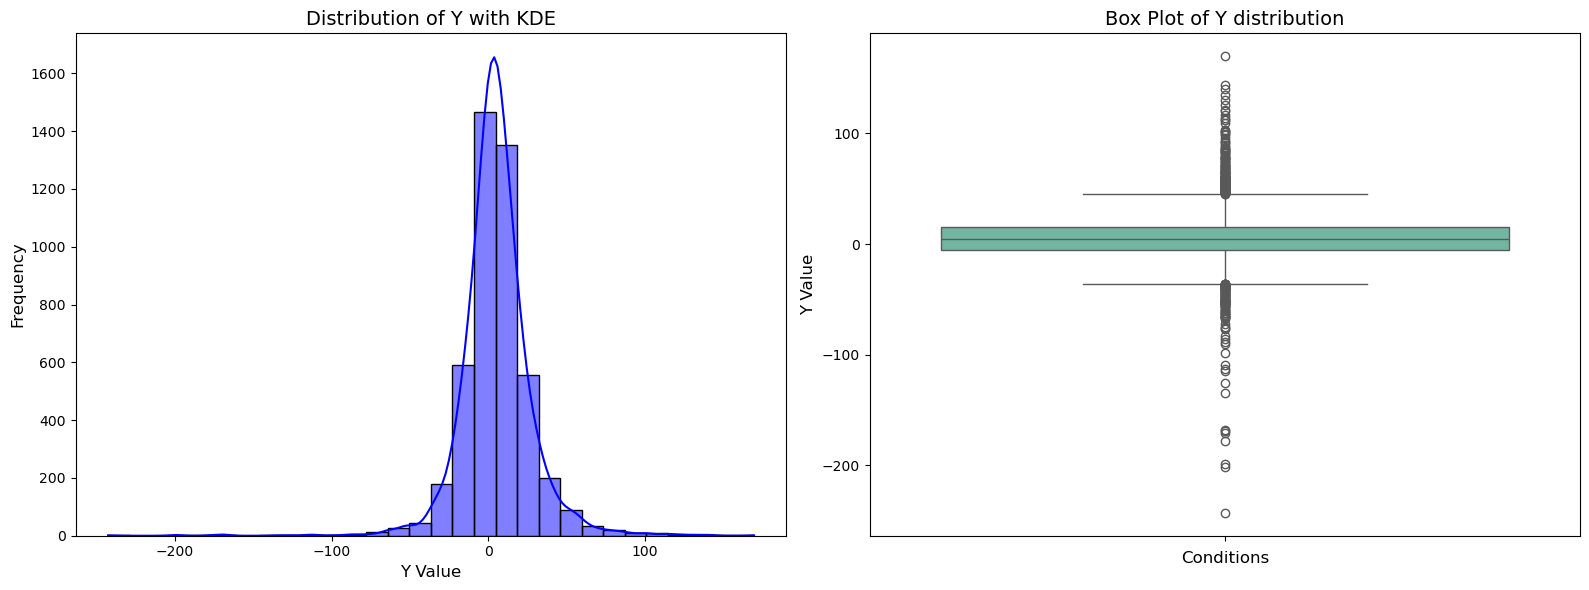

In [97]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# histogram with kde
sns.histplot(test_data['Y'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title("Distribution of Y with KDE", fontsize=14)
axes[0].set_xlabel("Y Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# box plot
sns.boxplot(y=test_data['Y'], palette='Set2', ax=axes[1])
axes[1].set_title("Box Plot of Y distribution", fontsize=14)
axes[1].set_xlabel("Conditions", fontsize=12)
axes[1].set_ylabel("Y Value", fontsize=12)

# adjust layout for better spacing
plt.tight_layout()

# show the plots
plt.show()

In [98]:
# quantitative identification of outliers (using iqr)
q1_test = test_data['Y'].quantile(0.25)
q3_test = test_data['Y'].quantile(0.75)
iqr_test = q3_train - q1_train

# defining the limits to identify outliers
lower_bound_test = q1_test - 1.5 * iqr_test
upper_bound_test = q3_test + 1.5 * iqr_test

# identifying outliers
outliers_test = test_data[(test_data['Y'] < lower_bound_test) | (test_data['Y'] > upper_bound_test)]
print("Number of outliers:", len(outliers_test))

# removing outliers
test_data_wo_outliers = test_data[~test_data.index.isin(outliers_test.index)]

# confirming removal of outliers
remaining_outliers_test = test_data_wo_outliers[(test_data_wo_outliers['Y'] < lower_bound_test) | (test_data_wo_outliers['Y'] > upper_bound_test)]
print("Number of outliers after removal:", len(remaining_outliers_test))

print(test_data.shape)
print(test_data_wo_outliers.shape)

Number of outliers: 269
Number of outliers after removal: 0
(4610, 7)
(4341, 7)


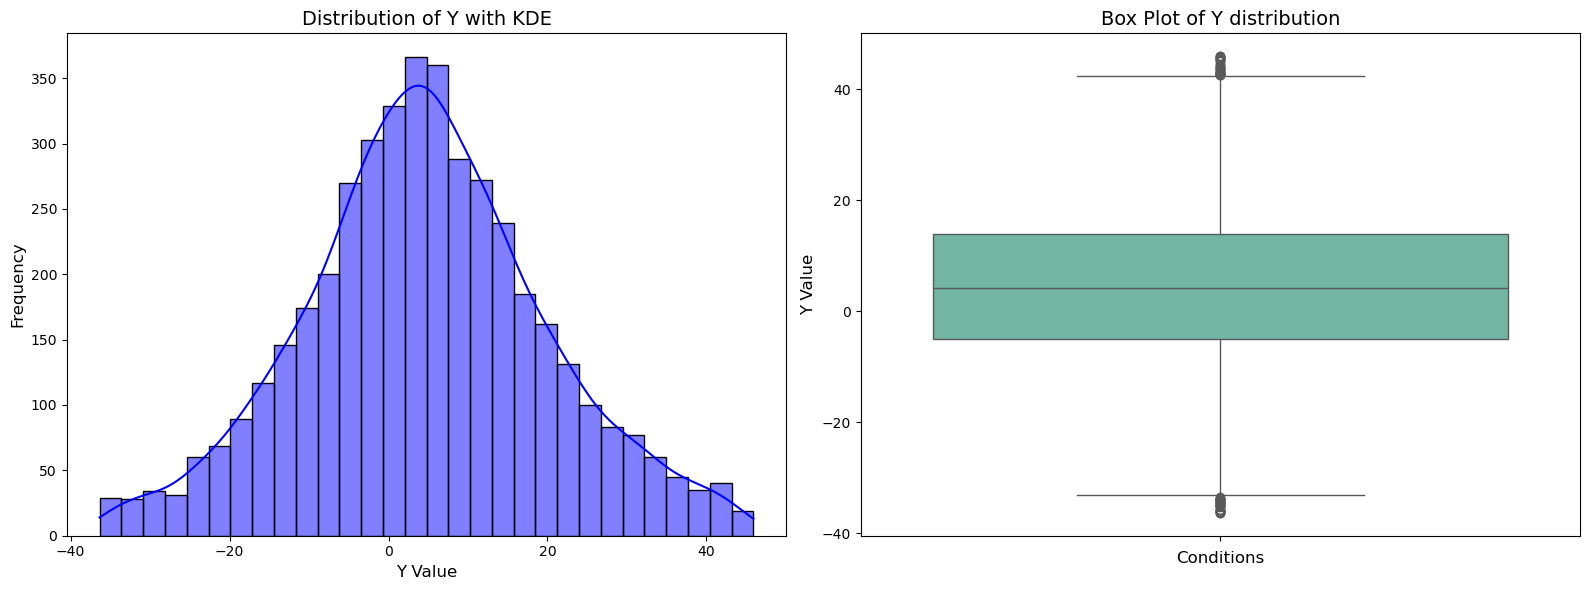

In [99]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# histogram with kde
sns.histplot(test_data_wo_outliers['Y'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title("Distribution of Y with KDE", fontsize=14)
axes[0].set_xlabel("Y Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# box plot
sns.boxplot(y=test_data_wo_outliers['Y'], palette='Set2', ax=axes[1])
axes[1].set_title("Box Plot of Y distribution", fontsize=14)
axes[1].set_xlabel("Conditions", fontsize=12)
axes[1].set_ylabel("Y Value", fontsize=12)

# adjust layout for better spacing
plt.tight_layout()

# show the plots
plt.show()

In [ ]:
genomic_features_test = test_data_wo_outliers['Cell_Line']
genomic_features_test = pd.DataFrame(genomic_features_test.tolist(), columns=[f'Genomic_{i}' for i in range(len(genomic_features_test.iloc[0]))])

# shape of the genomic features dataframe
print(genomic_features_test.shape)
# remove rows with nan values
genomic_features_test = genomic_features_test.dropna()

# as we can see, the shapes are the same so there were no nan values
print(genomic_features_test.shape)

# check if there are columns with nan values in the genomic features dataframe
print(genomic_features_test.isna().any().sum())

(4610, 8785)
(4610, 8785)
0


In [53]:
# standardize drug1 and drug2
standardized_drug1_test = test_data_wo_outliers.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
standardized_drug2_test = test_data_wo_outliers.copy().apply(lambda x: standardize(x['Drug2']), axis=1)

In [54]:
unique_drug1_test = list(test_data_wo_outliers['Drug1'].unique())
unique_drug1_id_test = list(test_data_wo_outliers['Drug1_ID'].unique())
unique_standardized_drug1_test = list(standardized_drug1_test.unique())

unique_drug2_test = list(test_data_wo_outliers['Drug2'].unique())
unique_drug2_id_test = list(test_data_wo_outliers['Drug2_ID'].unique())
unique_standardized_drug2_test = list(standardized_drug2_test.unique())

Unique Drug1 molecules


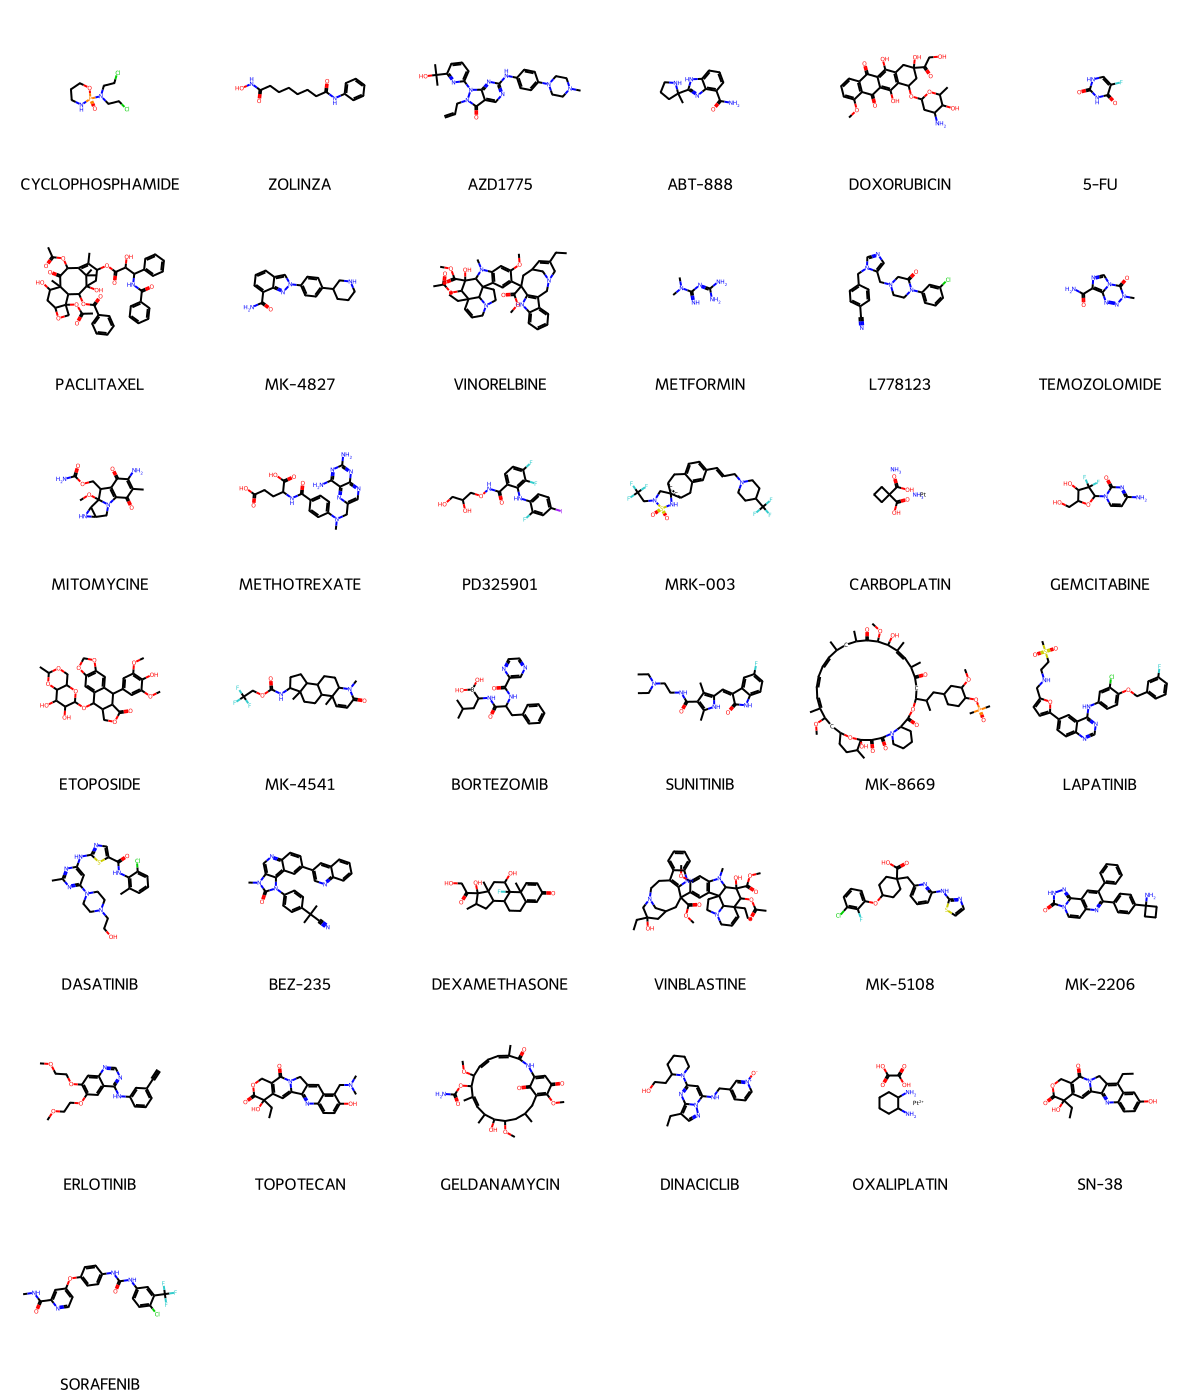

In [ ]:
print("Unique Drug1 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug1_test], molsPerRow=6, legends=unique_drug1_id_test)

Unique Drug1 molecules


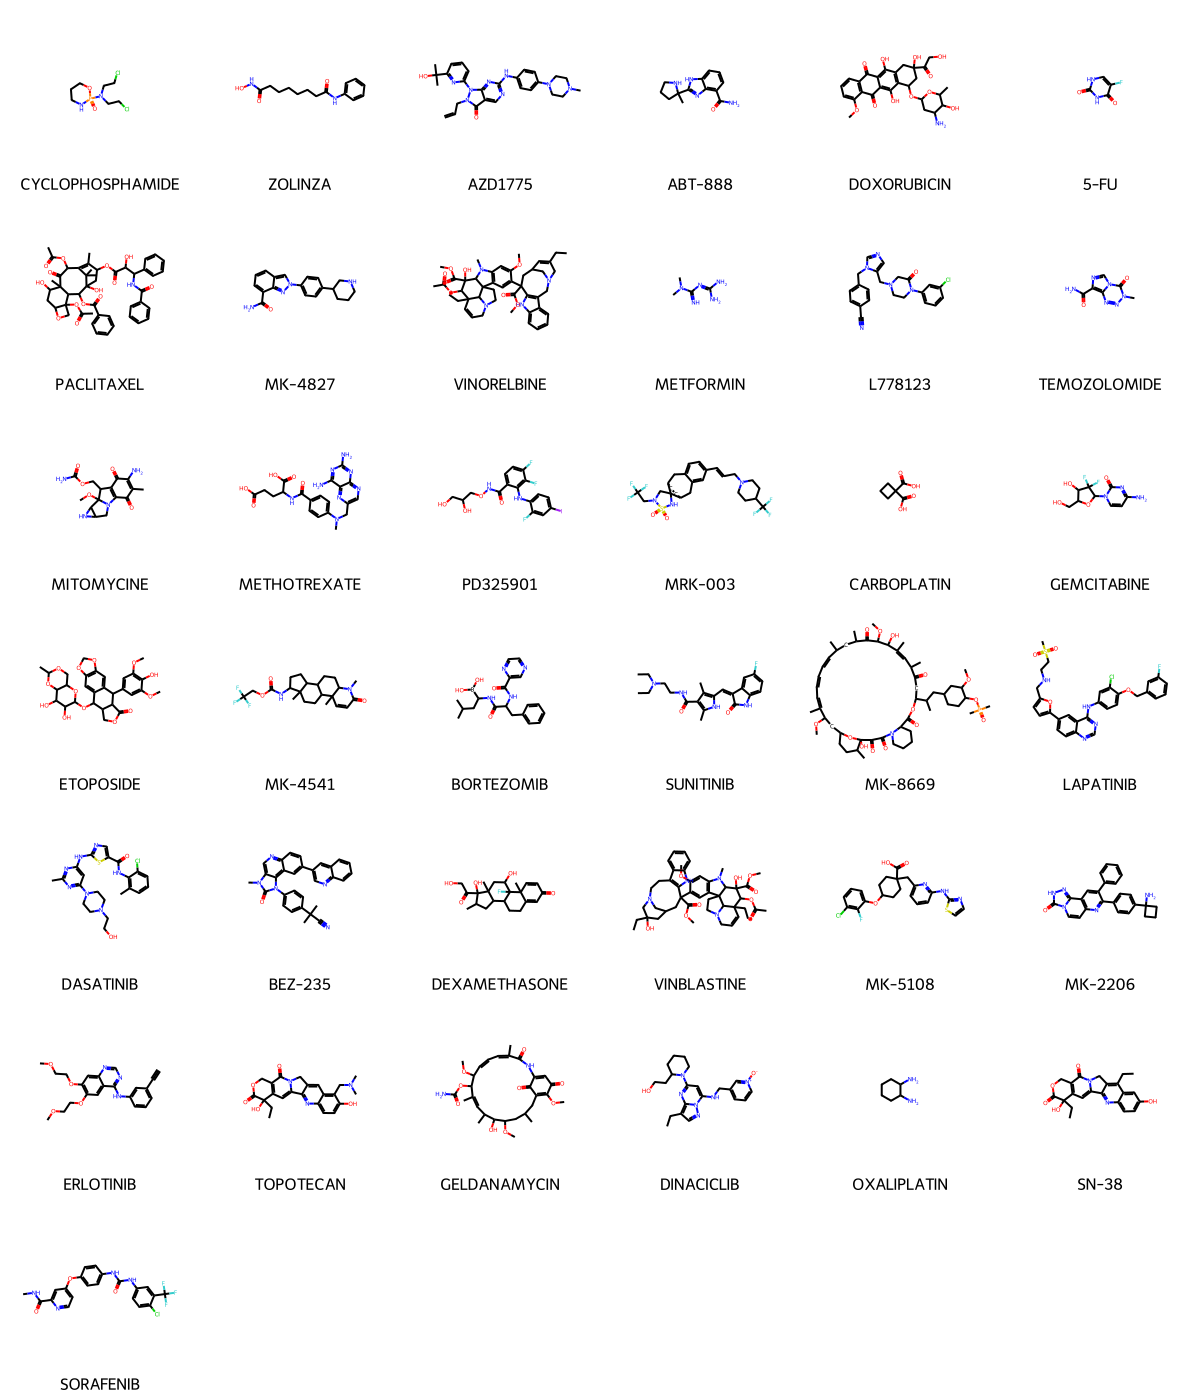

In [ ]:
print("Unique Drug1 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_standardized_drug1_test], molsPerRow=6, legends=unique_drug1_id_test)

Unique Drug2 molecules


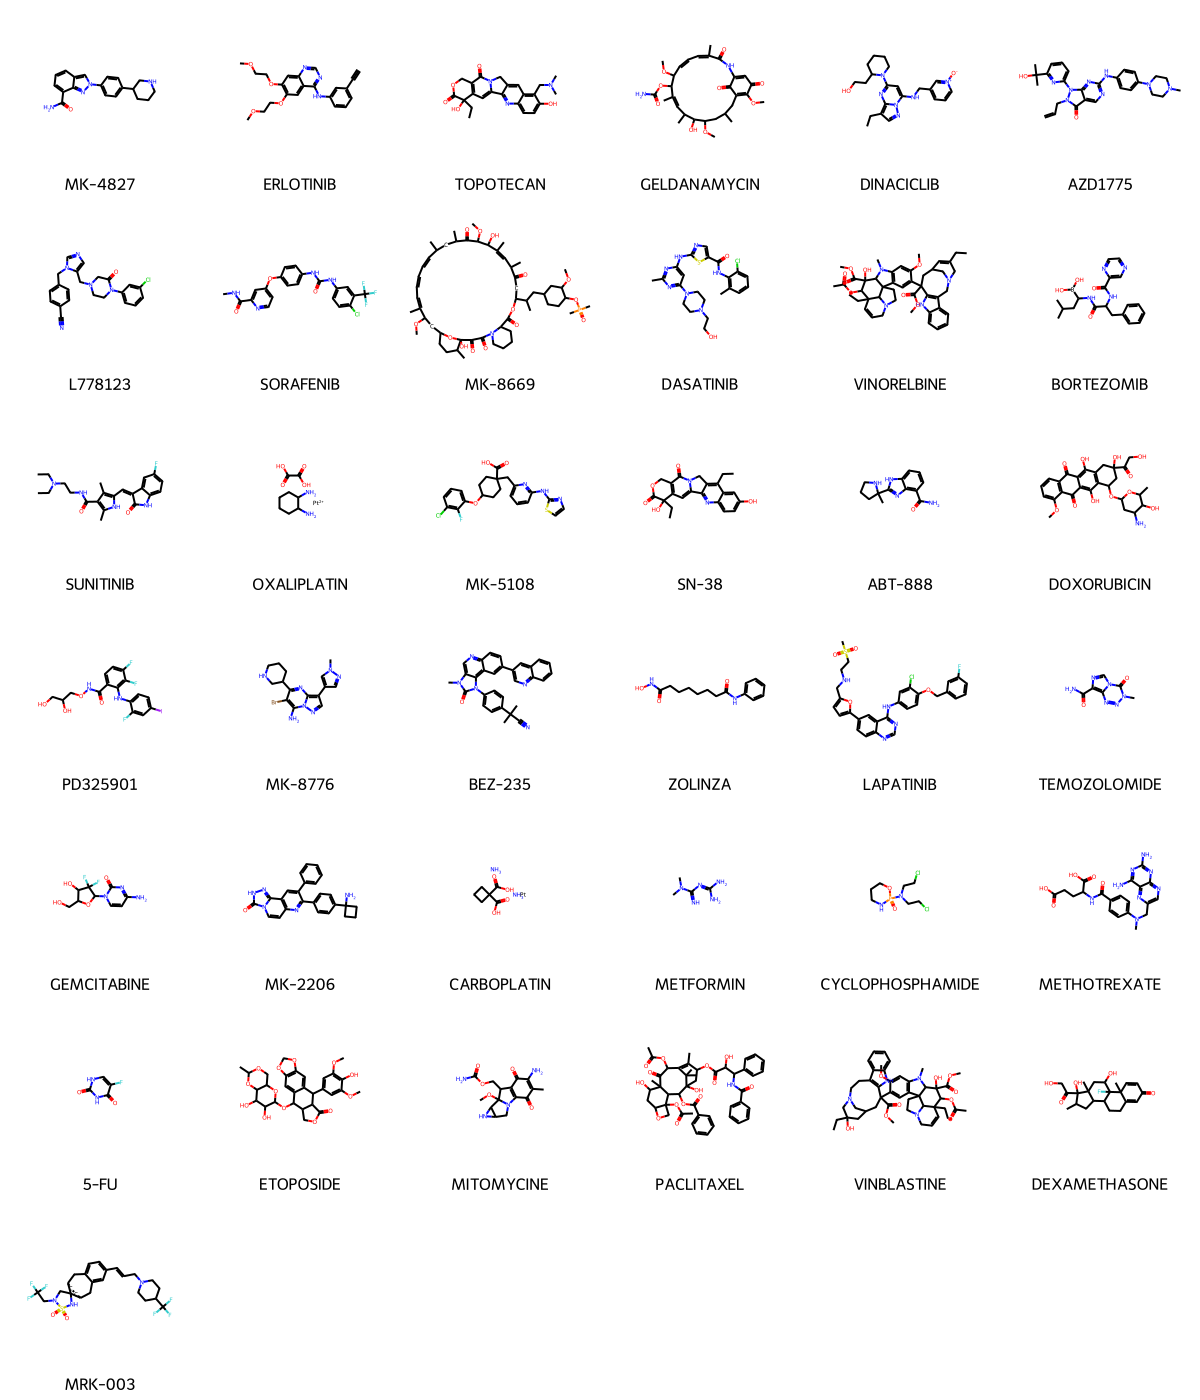

In [ ]:
print("Unique Drug2 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_drug2_test], molsPerRow=6, legends=unique_drug2_id_test)

Unique Drug2 molecules


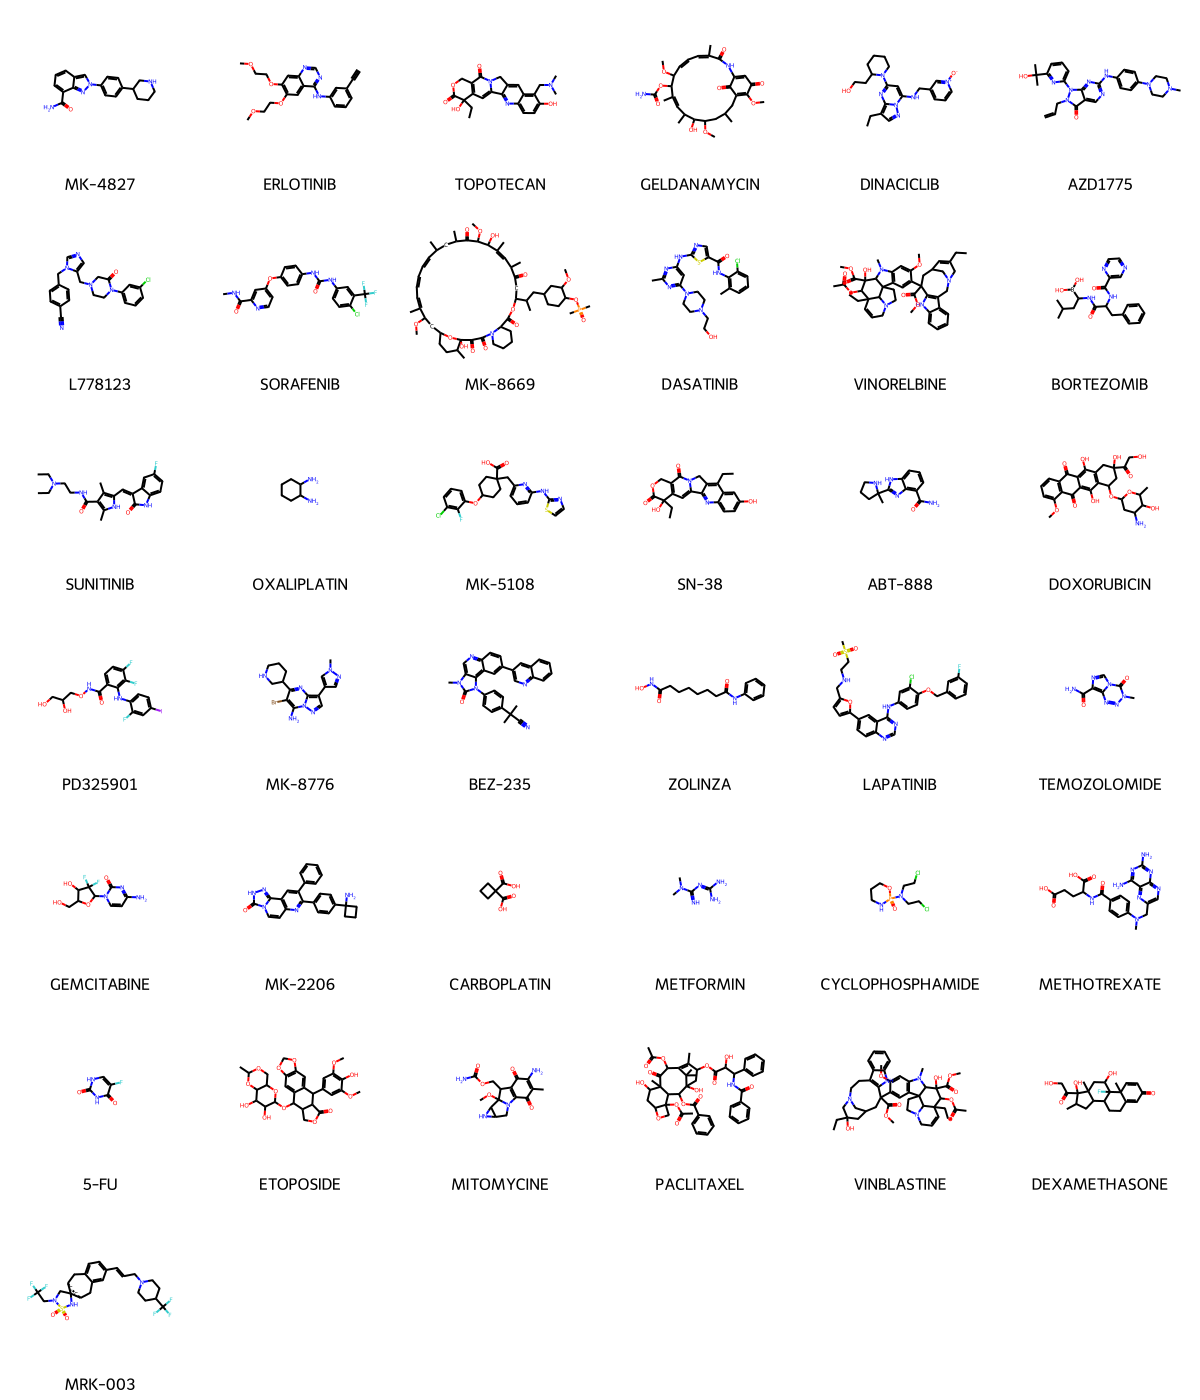

In [ ]:
print("Unique Drug2 molecules")
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(drug) for drug in unique_standardized_drug2_test], molsPerRow=6, legends=unique_drug2_id_test)

In [ ]:
# calculate descriptors for drug1
descriptors_drug1_test = standardized_drug1_test.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug1_test = pd.DataFrame(descriptors_drug1_test.values.tolist(), columns=[f'{x[0]}_drug1' for x in Descriptors._descList])

# calculate descriptors for drug2
descriptors_drug2_test = standardized_drug2_test.apply(lambda x: get_descriptors(x))
# convert to dataframe
descriptors_drug2_test = pd.DataFrame(descriptors_drug2_test.values.tolist(), columns=[f'{x[0]}_drug2' for x in Descriptors._descList])

# calculate morgan fingerprints for drug1
morgan_fingerprints_drug1_test = standardized_drug1_test.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug1_test = pd.DataFrame(morgan_fingerprints_drug1_test.values.tolist(), columns=[f'Morgan_{i}_drug1' for i in range(1024)])

# calculate morgan fingerprints for drug2
morgan_fingerprints_drug2_test = standardized_drug2_test.apply(lambda x: get_morgan_fingerprints(x))
# convert to dataframe
morgan_fingerprints_drug2_test = pd.DataFrame(morgan_fingerprints_drug2_test.values.tolist(), columns=[f'Morgan_{i}_drug2' for i in range(1024)])

# shape of the drug1 dataframes
print(descriptors_drug1_test.shape, morgan_fingerprints_drug1_test.shape)
# remove rows where all values are nan
descriptors_drug1_test = descriptors_drug1_test.dropna(how='all')
# we do the same for morgan_fingerprints
morgan_fingerprints_drug1_test = morgan_fingerprints_drug1_test.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
print(descriptors_drug1_test.shape, morgan_fingerprints_drug1_test.shape)

# check if there are columns with nan values in the drug1 dataframes
print(descriptors_drug1_test.isna().any().sum(), morgan_fingerprints_drug1_test.isna().any().sum())

# shape of the drug2 dataframes
print(descriptors_drug2_test.shape, morgan_fingerprints_drug2_test.shape)
# remove rows where all values are nan
descriptors_drug2_test = descriptors_drug2_test.dropna(how='all')
# we do the same for morgan_fingerprints
morgan_fingerprints_drug2_test = morgan_fingerprints_drug2_test.dropna(how='all')
# as we can see, the shapes are the same, because there was no invalid molecule
print(descriptors_drug2_test.shape, morgan_fingerprints_drug2_test.shape)

# check if there are columns with nan values in the drug2 dataframes
print(descriptors_drug2_test.isna().any().sum(), morgan_fingerprints_drug2_test.isna().any().sum())

(4610, 210) (4610, 1024)
(4610, 210) (4610, 1024)
0 0
(4610, 210) (4610, 1024)
(4610, 210) (4610, 1024)
0 0


In [ ]:
# scale drug1 descriptors data
scaled_descriptors_drug1_test = scaler.fit_transform(descriptors_drug1_test)

# scale drug2 descriptors data
scaled_descriptors_drug2_test = scaler.fit_transform(descriptors_drug2_test)

# scale genomic features data
scaled_genomic_features_test = scaler.fit_transform(genomic_features_test)

# select drug1 and drug2 descriptores
selector = VarianceThreshold(threshold=0.01)

# selected drug1 descriptors
selected_descriptors_drug1_test = selector.fit_transform(scaled_descriptors_drug1_test)
selected_columns = descriptors_drug1_test.columns[selector.get_support()]
# convert selected drug1 descriptors numpy array into a pandas dataframe
selected_descriptors_drug1_test = pd.DataFrame(selected_descriptors_drug1_test, columns=selected_columns)

# selected drug2 descriptors
selected_descriptors_drug2_test = selector.fit_transform(scaled_descriptors_drug2_test)
selected_columns = descriptors_drug2_test.columns[selector.get_support()]
# convert selected drug2 descriptors numpy array into a pandas dataframe
selected_descriptors_drug2_test = pd.DataFrame(selected_descriptors_drug2_test, columns=selected_columns) 

# select drug1 and drug2 morgan fingerprints
selector = VarianceThreshold(threshold=0.01)

# selected drug1 morgan fingerprints
selected_morgan_fingerprints_drug1_test = selector.fit_transform(morgan_fingerprints_drug1_test)
selected_columns = morgan_fingerprints_drug1_test.columns[selector.get_support()]
# convert selected drug1 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug1_test = pd.DataFrame(selected_morgan_fingerprints_drug1_test, columns=selected_columns) 

# selected drug2 morgan fingerprints
selected_morgan_fingerprints_drug2_test = selector.fit_transform(morgan_fingerprints_drug2_test)
selected_columns = morgan_fingerprints_drug2_test.columns[selector.get_support()]
# convert selected drug2 morgan fingerprints numpy array into a pandas dataframe
selected_morgan_fingerprints_drug2_test = pd.DataFrame(selected_morgan_fingerprints_drug2_test, columns=selected_columns) 

# select drug1 and drug2 genomic features
selector = VarianceThreshold(threshold=0.01)

# selected genomic features
selected_genomic_features_test = selector.fit_transform(scaled_genomic_features_test)
selected_columns = genomic_features_test.columns[selector.get_support()] 
# convert selected genomic features numpy array into a pandas dataframe
selected_genomic_features_test = pd.DataFrame(selected_genomic_features_test, columns=selected_columns) 

y_label_test = test_data_wo_outliers['Y']
type(y_label_test)
test_dataset = pd.concat([selected_genomic_features_test, 
                           selected_descriptors_drug1_test,
                           selected_descriptors_drug2_test,
                           selected_morgan_fingerprints_drug1_test,
                           selected_morgan_fingerprints_drug2_test,
                           y_label_test], 
                           axis=1)
print(test_dataset.shape)
test_dataset.head()

# test_dataset.to_csv('test_dataset')

(4610, 10319)


Genomic_0  Genomic_1  Genomic_2  Genomic_3  Genomic_4  Genomic_5  \
0  -0.185904   -0.19746  -0.185904  -0.946081  -0.394561  -0.185904   
1  -0.185904   -0.19746  -0.185904   1.503514  -0.394561  -0.185904   
2  -0.185904   -0.19746  -0.185904   0.917851  -0.394561  -0.185904   
3  -0.185904   -0.19746  -0.185904   0.917851  -0.394561  -0.185904   
4  -0.185904   -0.19746  -0.185904   0.917851  -0.394561  -0.185904   

   Genomic_6  Genomic_7  Genomic_8  Genomic_9  ...  Morgan_1004_drug2  \
0  -0.185904  -1.385078  -0.673818  -0.895621  ...                0.0   
1  -0.185904  -0.912777  -0.673818  -0.895621  ...                0.0   
2  -0.185904   0.817914  -0.673818   1.672021  ...                0.0   
3  -0.185904  -1.006519  -0.673818   0.582699  ...                0.0   
4  -0.185904  -1.006519  -0.673818   0.582699  ...                0.0   

   Morgan_1005_drug2  Morgan_1009_drug2  Morgan_1010_drug2  Morgan_1011_drug2  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0   
3                0.0                0.0                1.0                1.0   
4                0.0                0.0                0.0                0.0   

   Morgan_1014_drug2  Morgan_1017_drug2  Morgan_1018_drug2  Morgan_1019_drug2  \
0                0.0                0.0                0.0                1.0   
1                0.0                0.0                0.0                1.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                1.0   

           Y  
0 -66.134218  
1  -3.809199  
2  14.652960  
3 -16.204517  
4 -17.080158  

[5 rows x 10319 columns]

In [61]:
test_dataset_X = test_dataset.drop('Y', axis=1)
test_dataset_y = test_dataset['Y']

# retain components that explain 99% of the variance
pca_test = PCA(n_components=0.99)
test_dataset_X_pca = pca_test.fit_transform(test_dataset_X)

# output the shape and explained variance ratio
print(f"Reduced dataset shape: {test_dataset_X_pca.shape}")
print(f"Explained Variance Ratio: {pca_test.explained_variance_ratio_}")

# create a dataframe with the pca-reduced dataset
test_dataset_pca = pd.DataFrame(test_dataset_X_pca)

# add the target variable into the reduced dataset
test_dataset_pca['Y'] = test_dataset_y

print(test_dataset_pca.shape)
test_dataset_pca.head()

Reduced dataset shape: (4610, 99)
Explained Variance Ratio: [0.16274226 0.04796679 0.04138323 0.03217198 0.02184454 0.02164421
 0.01988823 0.01932864 0.01768055 0.01691601 0.01568922 0.01512512
 0.01350061 0.01313448 0.0126039  0.01204002 0.01182982 0.01108787
 0.01090992 0.01071821 0.01036927 0.01006265 0.00992729 0.00982561
 0.0093296  0.00916574 0.00904452 0.00890357 0.00873782 0.00864631
 0.00852387 0.00846872 0.00831652 0.00804248 0.00791645 0.00782418
 0.00773615 0.0074813  0.00738334 0.00735632 0.00729063 0.00710974
 0.00706474 0.00689399 0.00676947 0.00666018 0.006575   0.00656925
 0.00638262 0.00624714 0.00621663 0.00617106 0.00611547 0.00604744
 0.00597052 0.00591822 0.00579247 0.00572258 0.00568576 0.00562046
 0.00555969 0.00550057 0.00543378 0.00531573 0.00530959 0.00514363
 0.00510696 0.00507345 0.0050285  0.0049062  0.00484089 0.00482178
 0.00479286 0.00475311 0.00468767 0.00464262 0.00458312 0.00451366
 0.00443827 0.00439832 0.00433793 0.00425773 0.00411304 0.00405382
 0

0          1          2          3          4          5  \
0  -18.598474 -26.172290 -18.164093  16.565588   5.626666 -16.542026   
1  -17.142712 -16.259492 -16.443894  22.279652   2.313781  -6.178866   
2  101.167952  14.222815   2.115523  -1.534398   4.589586  -2.012409   
3  -10.080047 -21.132139   7.559850  25.816801  -2.693881 -13.839799   
4   99.975281 -25.758489  26.517110  -4.107782 -15.526826   1.186478   

           6          7          8          9  ...         90         91  \
0 -19.191404  13.729092   2.792426  -3.913262  ... -11.097787  12.625538   
1  -8.116666   5.198965  13.231349 -17.754224  ...   3.541037   1.072917   
2  -6.125826 -15.230711  -2.442983  -6.382867  ...   2.848671  -0.439176   
3  10.335748  -7.179723   5.868546 -21.504664  ...  -5.552970  -4.845901   
4  -4.936762  -1.366573   7.566408   9.079443  ...  -1.166013  -2.169253   

         92        93         94        95        96        97         98  \
0 -2.854209  1.547426   0.936617  2.255688  2.637114 -0.603131   1.228108   
1 -0.474666  6.410620   3.696963  1.735389 -0.110205  1.028903  -0.237654   
2 -1.728905 -0.170125   1.688246 -0.707996 -0.217847  0.162138   1.676366   
3 -2.613450 -4.797476 -12.325194 -1.761066  0.291961  6.280244  38.934764   
4 -1.025343 -4.884228   4.762200 -0.138442  3.945513  5.353743  37.779366   

           Y  
0 -66.134218  
1  -3.809199  
2  14.652960  
3 -16.204517  
4 -17.080158  

[5 rows x 100 columns]

In [71]:
# save to CSV
test_dataset_pca.to_csv('test_dataset_reduced.csv', index=False)

In [63]:
# falta acrescentar a análise exploratória antes do pré processamento
# falta ver se é para excluir os outliers e acrescentar esse código

In [64]:
# perguntar se devemos fazer o feature selection nas morgan fingerprints